This notebook evaluates the final modelling pipeline using an alternative 75/15/10 train-validation-test split as a robustness check. This experiment is for supplementary analysis only.

In [1]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1.Import Libraries

In [2]:
#main python and data handline libraries
import numpy as np
import pandas as pd
import os, random, re, html, unicodedata
from html import unescape
from collections import Counter

#visualisation
import matplotlib.pyplot as plt
import seaborn as sns

#machine learning & evaluation metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, precision_recall_curve, average_precision_score
from sklearn.model_selection import train_test_split
from transformers import EarlyStoppingCallback

#transformers
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import(AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding)
from typing import List, Dict, Optional

import joblib
import sys

#add project root to Python path to import utils.py
sys.path.append('/content/drive/MyDrive/applied_research_project')
import utils

# 2.Load the GoEmotion Train, Test, and Val Splits from the official Google Research Repository

In [3]:
#load the GoEmotions train split from the official Google Research Repository
train_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/train.tsv'
train_df=pd.read_csv(train_url,sep='\t',header=None)
print(train_df.shape)
train_df.head()

(43410, 3)


,0,1,2
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [4]:
#change the colum names of the train split
train_df.columns = ["text", "emotion_id", "comment_id"]
train_df.head()

,text,emotion_id,comment_id
0,My favourite food is anything I didn't have to...,27,eebbqej
1,"Now if he does off himself, everyone will thin...",27,ed00q6i
2,WHY THE FUCK IS BAYLESS ISOING,2,eezlygj
3,To make her feel threatened,14,ed7ypvh
4,Dirty Southern Wankers,3,ed0bdzj


In [5]:
#load the GoEmotions test split from the official Google Research Repository
test_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/test.tsv'
test_df=pd.read_csv(test_url,sep='\t', header=None)
print(test_df.shape)
test_df.head()

(5427, 3)


,0,1,2
0,I’m really sorry about your situation :( Altho...,25,eecwqtt
1,It's wonderful because it's awful. At not with.,0,ed5f85d
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1
4,They got bored from haunting earth for thousan...,27,eem5uti


In [6]:
#change the colum names of the test split
test_df.columns = ["text", "emotion_id", "comment_id"]
test_df.head()

,text,emotion_id,comment_id
0,I’m really sorry about your situation :( Altho...,25,eecwqtt
1,It's wonderful because it's awful. At not with.,0,ed5f85d
2,"Kings fan here, good luck to you guys! Will be...",13,een27c3
3,"I didn't know that, thank you for teaching me ...",15,eelgwd1
4,They got bored from haunting earth for thousan...,27,eem5uti


In [7]:
#load the GoEmotions val split from the official Google Research Repository
val_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/dev.tsv'
val_df=pd.read_csv(val_url, sep='\t', header=None)
print(val_df.shape)
val_df.head()

(5426, 3)


,0,1,2
0,Is this in New Orleans?? I really feel like th...,27,edgurhb
1,"You know the answer man, you are programmed to...","4,27",ee84bjg
2,I've never been this sad in my life!,25,edcu99z
3,The economy is heavily controlled and subsidiz...,"4,27",edc32e2
4,He could have easily taken a real camera from ...,20,eepig6r


In [8]:
#change the colum names of the val split
val_df.columns = ["text", "emotion_id", "comment_id"]
val_df.head()

,text,emotion_id,comment_id
0,Is this in New Orleans?? I really feel like th...,27,edgurhb
1,"You know the answer man, you are programmed to...","4,27",ee84bjg
2,I've never been this sad in my life!,25,edcu99z
3,The economy is heavily controlled and subsidiz...,"4,27",edc32e2
4,He could have easily taken a real camera from ...,20,eepig6r


In [9]:
#load the GoEmotions emotion list from the official Google Research Repository
emotions_url='https://raw.githubusercontent.com/google-research/google-research/refs/heads/master/goemotions/data/emotions.txt'
emotions=pd.read_csv(emotions_url,header=None)

print(f"Total num of emotions: ", len(emotions), '\n')
for emo in emotions[0]:
  print(emo)


Total num of emotions:  28 

admiration
amusement
anger
annoyance
approval
caring
confusion
curiosity
desire
disappointment
disapproval
disgust
embarrassment
excitement
fear
gratitude
grief
joy
love
nervousness
optimism
pride
realization
relief
remorse
sadness
surprise
neutral


# 3.Combine All Splits, and Resplit Into 75/15/10

In [10]:
#combine all splits
full_df=pd.concat([train_df, val_df, test_df], ignore_index=True)
print("Full dataset shape:", full_df.shape)

Full dataset shape: (54263, 3)


In [11]:
#resplit the full dataset into 75/15/10

#first resplit into 75% train and 25% temp
train_df, temp_df= train_test_split(
    full_df,
    test_size=0.25,
    random_state=42,
    shuffle=True
)

#split the 25% temp into 15% test and 10% val
val_df, test_df=train_test_split(
    temp_df,
    test_size=0.40,
    random_state=42,
    shuffle=True
)

print("New split sizes: 75% train, 15% val, 10% test")
print("\nTrain df shape: ", train_df.shape)
print("\nVal df shape: ", val_df.shape)
print("\nTest df shape: ", test_df.shape)

New split sizes: 75% train, 15% val, 10% test

Train df shape:  (40697, 3)

Val df shape:  (8139, 3)

Test df shape:  (5427, 3)


# 4.Text Cleaning and Preprocessing Setup

## 4.1. Initial Cleaning and Deduplication

In [12]:
#drop comment_id column from all splits
train_df=train_df.drop(columns=["comment_id"])
test_df=test_df.drop(columns=["comment_id"])
val_df=val_df.drop(columns=["comment_id"])

In [13]:
#combine train, test, and val splits into one dataframe
df_all = pd.concat([train_df, test_df, val_df], ignore_index=True)

#add emotion_label column in alignment with emotion id
df_all["emotion_label"] = df_all["emotion_id"].apply(
  lambda x: [emotions.iloc[int(i), 0] for i in str(x).split(',')]
)

In [14]:
#detect num of missing or empty text rows
text_is_null  = df_all["text"].isna()
text_is_blank = df_all["text"].astype(str).str.strip().eq("")
print(f"Total num of missing or empty text rows", (text_is_null | text_is_blank).sum())

Total num of missing or empty text rows 0


In [15]:
#check for missing text and/or emotion labels in each data split
def check_empty_text_or_emotion(df, split="split"):
    print(f"\n{split} Split:\n")

    total=len(df)

    no_text=text_is_null|text_is_blank
    no_label=df["emotion_id"].isna()|df["emotion_id"].astype(str).str.strip().eq("")

    has_text_but_no_label=((~no_text)&no_label).sum()
    has_label_but_no_text=((no_text)&(~no_label)).sum()
    no_label_and_no_text=((no_text)&(no_label)).sum()


    print(f"Total num of rows: {total:,}")
    print(f"Num of rows with text but no emotion_id: {has_text_but_no_label:,}")
    print(f"Num of rows with emotion_id but no text: {has_label_but_no_text:,}")
    print(f"Num of rows with no emotion_id and no text: {no_label_and_no_text:,}")

check_empty_text_or_emotion(train_df, "Train")
check_empty_text_or_emotion(test_df, "Test")
check_empty_text_or_emotion(val_df, "Val")



Train Split:

Total num of rows: 40,697
Num of rows with text but no emotion_id: 0
Num of rows with emotion_id but no text: 0
Num of rows with no emotion_id and no text: 0

Test Split:

Total num of rows: 5,427
Num of rows with text but no emotion_id: 0
Num of rows with emotion_id but no text: 0
Num of rows with no emotion_id and no text: 0

Val Split:

Total num of rows: 8,139
Num of rows with text but no emotion_id: 0
Num of rows with emotion_id but no text: 0
Num of rows with no emotion_id and no text: 0


In [16]:
#check pure duplicates and duplicates with different emotion_ids
def check_duplicates(df, split="dataset"):
  print(f"\n{split} Split:\n")
  duplicates=df["text"].duplicated(keep=False)

  gp_unique_duplicates=df.loc[duplicates].groupby("text")["emotion_id"].agg(lambda s: sorted(pd.unique(s))).reset_index() #gp duplicates by text and collect unique labels
  if gp_unique_duplicates.empty:
      print("No duplicate texts.")
      return gp_unique_duplicates

  gp_unique_duplicates["num_unique_labels"]=gp_unique_duplicates["emotion_id"].apply(len) #add additional column that display num of unique labels a text has

  duplicates_diff_labels=gp_unique_duplicates[gp_unique_duplicates["num_unique_labels"]>1]
  real_duplicates=gp_unique_duplicates[gp_unique_duplicates["num_unique_labels"]==1]

  print(f"Total num of texts with duplicates: {len(gp_unique_duplicates):,}")
  print(f"Num of same text with different emotion_id: {len(duplicates_diff_labels):,}")
  print(f"Num of pure duplicates: {len(real_duplicates)}")

#run the duplicate check for each data split
check_duplicates(train_df, "Train")
check_duplicates(test_df, "Test")
check_duplicates(val_df, "Val")


Train Split:

Total num of texts with duplicates: 95
Num of same text with different emotion_id: 45
Num of pure duplicates: 50

Test Split:

Total num of texts with duplicates: 4
Num of same text with different emotion_id: 3
Num of pure duplicates: 1

Val Split:

Total num of texts with duplicates: 8
Num of same text with different emotion_id: 4
Num of pure duplicates: 4


In [17]:
#merge emotion labels for duplicated texts with different emotion_ids

def merge_unique_duplicates(df, split="dataset"):
  num_before_merging=len(df)

  #convert the emotion_id values to a list
  def to_list(x):
      if not isinstance(x, str) or not x.strip():
        return []
      return [int(i) for i in x.split(',') if i]

  temp_df = df.copy()
  temp_df["emotion_id"] = temp_df["emotion_id"].apply(to_list)

  merged_df=(
      temp_df.groupby("text", as_index=False).agg({
          "emotion_id": lambda s: sorted(set(e for lst in s for e in lst))
      })
  )

  return merged_df

In [18]:
#merge train split and deduplicate test/val splits to avoid data leakage

ws_re = re.compile(r"\s+") #matches and collapse whitespaces

#create a deduplicate key by normalizing text to ensure duplicates can be identified across all splits
def deduplicate_key(s: str) -> str:
    if not isinstance(s, str):
        return ""
    return ws_re.sub(" ", html.unescape(s).lower()).strip()

#merge duplicate texts in train split and apply deduplication key
train_merged = merge_unique_duplicates(train_df, "Train")
train_merged["key"] = train_merged["text"].apply(deduplicate_key)

#deduplicate val and test splits, keep the first occurence, and apply deduplication key
val_deduplicate  = val_df.drop_duplicates(subset=["text"], keep="first").copy()
test_deduplicate = test_df.drop_duplicates(subset=["text"], keep="first").copy()

val_deduplicate["key"]  = val_deduplicate["text"].apply(deduplicate_key)
test_deduplicate["key"] = test_deduplicate["text"].apply(deduplicate_key)

#remove texts in val/test that also appear in train to avoid data leakage
train_keys = set(train_merged["key"])
val_final  = val_deduplicate[~val_deduplicate["key"].isin(train_keys)].reset_index(drop=True)
test_final = test_deduplicate[~test_deduplicate["key"].isin(train_keys)].reset_index(drop=True)

#remove deduplication key and retain original columns
train_final = train_merged[["text", "emotion_id"]].copy()
val_final   = val_final[["text", "emotion_id"]].copy()
test_final  = test_final[["text", "emotion_id"]].copy()

print(f"Train Split: {len(train_df):,}, after merging: {len(train_final):,}")
print(f"Test Split: {len(test_df):,}, after removing overlaps: {len(test_final):,} (overlaps removed: {len(test_df)-len(test_final):,})")
print(f"Val Split: {len(val_df):,}, after removing overlaps: {len(val_final):,}  (overlaps removed: {len(val_df)-len(val_final):,})")

Train Split: 40,697, after merging: 40,543
Test Split: 5,427, after removing overlaps: 5,376 (overlaps removed: 51)
Val Split: 8,139, after removing overlaps: 8,064  (overlaps removed: 75)


In [19]:
#confirm agin that val and test splits share no texts with training data
assert not set(val_final["text"].apply(deduplicate_key)).intersection(set(train_final["text"].apply(deduplicate_key)))
assert not set(test_final["text"].apply(deduplicate_key)).intersection(set(train_final["text"].apply(deduplicate_key)))

The assert statement in Python is used as a sanity check or validation.
It tests whether a condition is True.
If it’s True, nothing happens (the program continues).
If it’s False, Python raises an AssertionError, stopping the program and signaling that something’s wrong.


## 4.2 Handling Text Artifacts

In [20]:
#check the presence of html entities (&, <,>, ",', space) in all splits
html_entities=df_all['text'].str.contains(r"&(?:amp|lt|gt|quot|apos|nbsp);").any()

#check the presence of zero_width characters in all splits
zero_width_char=df_all['text'].str.contains(r"[\u0000-\u001F\u007F\u200B-\u200F\uFEFF\u115F\u1160\u3164\uFFA0\uFFFC\uFFF0-\uFFF8]").any()

print("Presence of HTML entities within all three splits:", html_entities)
print("Presence of zero_width characters within all three splits:", zero_width_char)

Presence of HTML entities within all three splits: False
Presence of zero_width characters within all three splits: True


In [21]:
#check count of patterns (emails, @-sign tokens, hashtags, subreddits, placeholders, etc.) within the text across all splits

regex_patterns = {
    "emails": r"""(?ix)\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b""",
    "at_sign_front": r"(?<!\w)@[A-Za-z0-9_][A-Za-z0-9_-]*",
    "at_sign_inside":r"\b\w*@\w*\b",
    "hashtags_front": r"(?<!\w)#[A-Za-z0-9_][A-Za-z0-9_-]*",
    "hashtags_inside":r"\b\w+#\w+\b",
    "placeholders": r"(?i)(\[\s*[a-z0-9_-]+\s*\]|<\s*[a-z0-9_-]+\s*>)",
    "subreddits": r"\br/[A-Za-z0-9_]+",
    "user_subreddits":r"\bu/[A-Za-z0-9_-]+",
}

#extract and count regex pattern occurrences
def extract_and_count(df, text, pattern):
    regex = re.compile(pattern)
    vals = df[text].astype(str).apply(lambda x: regex.findall(x)).explode()
    counts = vals.value_counts(dropna=True).to_frame(name="count")
    return counts

results = {}
for name, pattern in regex_patterns.items():
    counts = extract_and_count(df_all, "text", pattern)
    results[name] = counts
    print(f"\n{name.upper()}:")
    display(counts)



EMAILS:


,count
text,



AT_SIGN_FRONT:


,count
text,
@me,1
@11,1
@teamYouTube,1
@AOC,1
@teamyoutube,1
@lies_about_flossing,1
@IAMTHESmoothOperator,1



AT_SIGN_INSIDE:


,count
text,
t@gged,1



HASHTAGS_FRONT:


,count
text,
#1,32
#2,8
#I,4
#x200B,3
#YES,3
...,...
#MAGAboys,1
#le,1
#ERROR,1



HASHTAGS_INSIDE:


,count
text,
xkcd#37,1



PLACEHOLDERS:


,count
text,
[NAME],9598
[RELIGION],132
[serious],2
[celebrity],1
[chuckles],1
[goshdarn],1
[Serious],1
<smile>,1
[7],1



SUBREDDITS:


,count
text,
r/politics,8
r/woooosh,6
r/funny,6
r/nba,5
r/niceguys,4
...,...
r/raisedbyborderlines,1
r/DFWPets,1
r/Politics,1



USER_SUBREDDITS:


,count
text,
u/JusticeForShangeIa,1
u/Jakurton,1
u/justforyouthlogic,1
u/FappingPedant,1
u/MeatheadVernacular,1
...,...
u/coffeewhore17,1
u/Goyteamsix,1
u/beelzebambi,1


In [22]:
#handle emails, and at_signs tokens (at the front and inside of words)
def handle_email_atSigns(text: str) -> str:
  email_re = re.compile(r"""(?ix)\b[A-Z0-9._%+-]+@[A-Z0-9.-]+\.[A-Z]{2,}\b""")
  atSign_front_re= re.compile(r"(?<!\w)@[A-Za-z0-9_][A-Za-z0-9_-]*")
  atSign_inside_re=re.compile(r"(?<=\w)@(?=\w)")

  text = email_re.sub(" <EMAIL> ", text)       #maps emails to <EMAIL>
  text = atSign_front_re.sub(" <USER> ", text) #maps to <USER> as '@' at the fron of word indicate mentions and tagged accounts
  text = atSign_inside_re.sub(" ", text)       #replace @ from the word with a whitespace
  text = re.sub(r"\s+", " ", text).strip()
  return text

In [23]:
#handle hashtags (at the front and inside of words)
def handle_hashtags(text: str) -> str:
  hashtag_inside_re=re.compile(r"(?<=\w)#(?=\w)")
  hashtag_start_re = re.compile(r"(?<!\w)#[A-Za-z0-9_][A-Za-z0-9_-]*")

  text = hashtag_inside_re.sub(" ", text) #replace hashtags with space
  text = hashtag_start_re.sub("", text)   #remove hashtag at the front of word

  return re.sub(r"\s+", " ", text).strip()

In [24]:
#handle placeholders
def handle_placeholders(text: str) -> str:
  placeholder_re = re.compile(r"(?i)(\[\s*[a-z0-9_-]+\s*\]|<\s*[a-z0-9_-]+\s*>)") #matches placeholders with [], and <>

  placeholder_map={
      #remove noise entirely
      "deleted": "", "get_user_id": "", "7": "", "t": "","all": "",

      #keep words that could provide emotion context
      "serious": "serious", "chuckles": "chuckles", "smile": "smile", "goshdarn": "goshdarn", "nice": "nice",

      #keep the placeholders
      "celebrity": "<ENTITY>", "name": "<NAME>", "religion": "<RELIGION>", "team": "<TEAM>",}

  def strip_brackets(s):
      key = s.group(0).strip("[]<>").strip().lower()
      val = placeholder_map.get(key, "")
      return f" {val} " if val else " "
  return placeholder_re.sub(strip_brackets, text)

In [25]:
#handle subreddit(e.g., r/xxx) and reddit users(e.g., u/xxx) references
def handle_subreddit_redditUsers(text: str) -> str:
  subreddits_re=re.compile(r"\br/[A-Za-z0-9_]+")
  reddit_user_re=re.compile(r"\bu/[A-Za-z0-9_-]+")

  text = subreddits_re.sub(" <SUBREDDIT> ", text) #replace (e.g., r/funny) with <SUBREDDIT> as they are identifiers that do not convey emotion
  text = reddit_user_re.sub(" <USER> ", text)     #replace (e.g., u/iBiteYou) with <USER> as they are identifiers that do not convey emotion
  text = re.sub(r"\s+", " ", text).strip()
  return text

In [26]:
#additional regex patterns

#matches real url
url_re=re.compile(r"https?://\S+|www\.\S+")

#matches zero-width characters
invisible_char_re=re.compile(r"[\u0000-\u001F\u007F\u200B-\u200F\uFEFF\u115F\u1160\u3164\uFFA0\uFFFC\uFFF0-\uFFF8]")

#matches words including the ones containing apostrophes'
word_re = re.compile(r"[a-zA-Z']+")

## 4.3. Handling Emoticons and Emojis

In [27]:
#map emoticons to their corresponding words

emoticons_to_words=[
    (re.compile(r"<3"), "love"),                              #<3
    (re.compile(r"\^_\^"), "smile"),                          # ^_^
    (re.compile(r"\*_\*"), "starstruck"),                     # *_*
    (re.compile(r">_\<"), "frustrated"),                      # >__<
    (re.compile(r"(?<!\w)[xX][dD](?!\w)"), "laugh"),          #XD, xd, Xd, xD
    (re.compile(r"(?<!\S):-?\)"), "smile"),                   # :) :-)
    (re.compile(r"(?<!\S):'\("), "cry"),                      # :'(
    (re.compile(r"(?<!\S):-?D"), "grin"),                     # :D :-D
    (re.compile(r"(?<!\S);-?\)"), "wink"),                    # ;) ;-)
    (re.compile(r"(?<!\S):-?\("), "sad"),                     # :( :-(
    (re.compile(r"(?<!\S):-?P\b", re.IGNORECASE), "playful"), # :P :-P
    (re.compile(r"(?<!\S):-?/",  re.IGNORECASE), "skeptical"),# :/ :-/
    (re.compile(r"(?<!\S):-?\\", re.IGNORECASE), "skeptical"),# :\ :-\
    (re.compile(r"(?<!\S):-?[oO]"), "surprised"),             # :o
    (re.compile(r"(?<!\S):-?\|"), "unimpressed"),             # :| :-|
]

#function for replacing emoticons with words
def replace_emoticons(text: str) -> str:
  for emo, p in emoticons_to_words:
      text = emo.sub(p, text)
  return text

In [28]:
#install emoji library
!pip -q install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 608.4/608.4 kB 13.7 MB/s eta 0:00:00


In [29]:
#demojise sample testing
import emoji

text = "I am so happy ☺️✨"
print("raw:", text)
print("demojized:", emoji.demojize(text, language="en"))

raw: I am so happy ☺️✨
demojized: I am so happy :smiling_face::sparkles:


## 4.4.Text Cleaning Pipelines for Transformer and Baseline Models

In [30]:
#function for data cleaning for transformers
def clean_for_transformer(text: str) -> str:
    if not isinstance(text, str): return "" #return "" for non-strings
    text = unicodedata.normalize("NFC", text)
    text = html.unescape(text)
    text = invisible_char_re.sub("", text)
    text = handle_placeholders(text)
    text = url_re.sub(" <URL> ", text)
    text = handle_email_atSigns(text)
    text = handle_hashtags(text)
    text = handle_subreddit_redditUsers(text)
    text = ws_re.sub(" ", text).strip()
    return text

In [31]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

#set up lemmatisation and stopword handling for baseline text cleaning
nltk.download('stopwords')
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
negation_words = {"no", "not", "never", "n't", "cannot", "neither", "nor", "none"}
stop_words -= negation_words

#function for data cleaning for baseline
def clean_for_baseline(s: str) -> str:
    if not isinstance(s, str): return ""

    #perform the same initial transformer cleaning function
    s = clean_for_transformer(s)

    #emoticons to words
    s = replace_emoticons(s)

    #demojize and remove : and _ from demojized words
    s = emoji.demojize(s, language="en")
    s = s.replace(":", " ")
    s = s.replace("_", " ")

    #map common punctuation cues to tokens
    markers = []
    if "?" in s: markers.append("__QUESTION_MARK__")
    if "!" in s: markers.append("__EXCLAIM__")
    if "..." in s: markers.append("__ELLIPSIS__")

    #lowercase,replace non letters with space and strip whitespaces
    s = s.lower()
    s = re.sub(r"[^a-z'\s]", " ", s)
    s = ws_re.sub(" ", s).strip() #strip whitespaces again as demojising and emoticons could introduce additional whitespaces

    #remove repeated punctuation and characters
    repeated_punc  = re.compile(r"([!?.,])\1{2,}") #match punctuations repeated 3+ times
    repeated_chars = re.compile(r"(.)\1{2,}")      #match chars repeated 3+ times
    s = repeated_chars.sub(r"\1\1", s)   #trim chars that are repeated for 3+ times (e.g, Hiiiiii-> Hii)
    s = repeated_punc.sub(r"\1\1\1", s)  #trim punctuations that are repeated for 3+ times (e.g, Hi!!!!!!!!-> Hi!!!)

    #tokenize, lemmatize and stopwords removal
    toks = word_re.findall(s) #tokenisation
    toks = [lemmatizer.lemmatize(t) for t in toks if t not in stop_words] #lemmantising

    #add puncutation markers back to tokens
    toks.extend(markers)

    return " ".join(toks)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [32]:
#sample testing to verify that the cleaning functions behave as expected
samples = [
    "Hi @Alice, email me at bob@example.com! #HappyDay",
    "Check this: https://ex.am/ple &amp; r/funny u/someUser",
    "Emoji ✨😊 + emoticon :-D ...wow!!!",
    "Inline hash covid#19 and start #Grateful #2024",
    "Zero\u200Bwidth here &nbsp; and <smile> [name] says hi",
]

#transformer-style cleaning
print("clean_for_transformer")
for s in samples:
    print("RAW: ", s)
    print("TRF:", clean_for_transformer(s))
    print("-"*60)

#baseline-style cleaning
print("\nclean_for_baseline")
for s in samples:
    print("RAW: ", s)
    print("BASE:", clean_for_baseline(s))
    print("-"*60)

clean_for_transformer
RAW:  Hi @Alice, email me at bob@example.com! #HappyDay
TRF: Hi <USER> , email me at <EMAIL> !
------------------------------------------------------------
RAW:  Check this: https://ex.am/ple &amp; r/funny u/someUser
TRF: Check this: <URL> & <SUBREDDIT> <USER>
------------------------------------------------------------
RAW:  Emoji ✨😊 + emoticon :-D ...wow!!!
TRF: Emoji ✨😊 + emoticon :-D ...wow!!!
------------------------------------------------------------
RAW:  Inline hash covid#19 and start #Grateful #2024
TRF: Inline hash covid 19 and start
------------------------------------------------------------
RAW:  Zero​width here &nbsp; and <smile> [name] says hi
TRF: Zerowidth here and smile <NAME> says hi
------------------------------------------------------------

clean_for_baseline
RAW:  Hi @Alice, email me at bob@example.com! #HappyDay
BASE: hi user email email __EXCLAIM__
------------------------------------------------------------
RAW:  Check this: https://ex.

In [33]:
train_final.head()

,text,emotion_id
0,"""If you don't wear BROWN AND ORANGE...YOU DON...","[3, 27]"
1,"'*Pray*, v. To ask that the laws of the unive...",[27]
2,">it'll get invaded by tankie, unfortunately. ...",[27]
3,And not all children's hospitals need the sam...,[4]
4,"Best number! [NAME], [NAME], [NAME]",[0]


# 5.Dataset Preparation for Modeling

## 5.1. Convert Emotion IDs, and Map Emotion Ids with Corresponding Labels

In [34]:
#convert the emotion_id col of test_df and val_df into list of ints separated by commas
for df in [val_final, test_final]:
  df["emotion_id"] = df["emotion_id"].astype(str).apply(
      lambda x: [int(e) for e in x.split(',') if e.strip().isdigit()]
  )

  #the emotion_id col of train_df has already been converted into list separated by commas, therefore, in this step we only did the conversion to val_df and test_df

In [35]:
#map emotion_ids with their corresponding emotion labels
for df in [train_final, val_final, test_final]:
  df["emotion_label"] = df["emotion_id"].apply(
      lambda ids: [emotions.iloc[i, 0] for i in ids])

In [36]:
train_final.head()

,text,emotion_id,emotion_label
0,"""If you don't wear BROWN AND ORANGE...YOU DON...","[3, 27]","[annoyance, neutral]"
1,"'*Pray*, v. To ask that the laws of the unive...",[27],[neutral]
2,">it'll get invaded by tankie, unfortunately. ...",[27],[neutral]
3,And not all children's hospitals need the sam...,[4],[approval]
4,"Best number! [NAME], [NAME], [NAME]",[0],[admiration]


## 5.2. Encode Labels

In [37]:
#label encoding
mlb = MultiLabelBinarizer()

#fit the label binarizer on the train split to learn all emotion classes
mlb.fit(train_final["emotion_label"])

#transform emotion labels into binary columns in all splits
for df in [train_final, val_final, test_final]:
  df_labels=pd.DataFrame(mlb.transform(df["emotion_label"]), columns=mlb.classes_, index=df.index)
  df[mlb.classes_]=df_labels

## 5.3. Drop Columns & Add Cleaned Text Columns for Baseline and Transformers

In [38]:
#drop emotion_id and emotion_label across all splits
for df in [train_final, test_final, val_final]:
    df.drop(columns=["emotion_id", "emotion_label"], inplace=True)

In [39]:
#add two columns of cleaned texts, one for transformers and the other for baseline
for df in [train_final, test_final, val_final]:
  df["text_transformer"] = df["text"].apply(clean_for_transformer)
  df["text_baseline"] = df["text"].apply(clean_for_baseline)


## 5.4. Prepare Input Features & Target Arrays for Baseline and Transformers


In [40]:
#prepare two versions of text inputs, one for baseline models and one for transformers
X_train_baseline=train_final["text_baseline"].tolist()
X_test_baseline=test_final["text_baseline"].tolist()
X_val_baseline=val_final["text_baseline"].tolist()

X_train_transformer=train_final["text_transformer"].tolist()
X_test_transformer=test_final["text_transformer"].tolist()
X_val_transformer=val_final["text_transformer"].tolist()

In [41]:
#prepare target arrays, shared by both baseline and transformer
label_cols = emotions[0].tolist()
y_train = train_final[label_cols].to_numpy(dtype="float32")
y_test = test_final[label_cols].to_numpy(dtype="float32")
y_val = val_final[label_cols].to_numpy(dtype="float32")

## 5.5. Convert Text to TF-IDF Features for Baseline Models


In [42]:
#vectorisation using tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(
    max_features=45000,
    ngram_range=(1,2),
    min_df=2
)
X_train_tfidf=tfidf.fit_transform(X_train_baseline)
X_val_tfidf=tfidf.transform(X_val_baseline)
X_test_tfidf=tfidf.transform(X_test_baseline)

# 6.Baseline Models


## 6.1. LR Model - Direct Category Training

In [43]:
#Logistic Regression - Direct Category Training
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

#map emotions to categories and create category and emotion id mappings
emo_to_cat=[utils.categorize_emotion(emotions.iloc[i, 0]) for i in range(len(emotions))]
categories=sorted(set(emo_to_cat))
cat_to_emoIds={cat: [i for i, c in enumerate(emo_to_cat) if c==cat] for cat in categories}

#convert train, val, and test emotion labels to category-level labels
y_train_cat=utils.y_to_categories(y_train, categories, cat_to_emoIds)
y_val_cat=utils.y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat=utils.y_to_categories(y_test, categories, cat_to_emoIds)

#initialize One-vs-Rest Logistic Regression with liblinear solver
baseline_lr_liblinear=OneVsRestClassifier(
    LogisticRegression(
         max_iter=1000,
         class_weight='balanced',
         solver='liblinear'
    )
)

#fit the model on train split with category-level labels
baseline_lr_liblinear.fit(X_train_tfidf, y_train_cat) #fit model on training data

#get predicted probabilities from val and test splits
val_scores_lr_cat= baseline_lr_liblinear.predict_proba(X_val_tfidf)
test_scores_lr_cat= baseline_lr_liblinear.predict_proba(X_test_tfidf)

#compute optimal per-label thresholds using val data
ts_label = utils.best_thresholds_per_label(val_scores_lr_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False) #get best thresholds per category

#evaluate model performance on val split
val_metrics_lr=utils.evaluate_run(y_val_cat, val_scores_lr_cat, ts_label, label_names=categories, title="LR Model (Val Split): Direct Category Training\nPer-Label Thresholds\n", return_metrics=True)

#evaluate model performance on test split
test_metrics_lr=utils.evaluate_run(y_test_cat, test_scores_lr_cat, ts_label, label_names=categories, title="LR Model (Test Split): Direct Category Training\nPer-Label Thresholds\n", return_metrics=True)



LR Model (Val Split): Direct Category Training
Per-Label Thresholds

Micro F1: 0.69
Macro F1: 0.66

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.64      0.86      0.73      3538
    pleasant_active       0.70      0.73      0.72      2456
  pleasant_deactive       0.83      0.64      0.72       970
  unpleasant_active       0.54      0.59      0.57      1390
unpleasant_deactive       0.57      0.55      0.56       569

          micro avg       0.65      0.74      0.69      8923
          macro avg       0.65      0.67      0.66      8923
       weighted avg       0.66      0.74      0.69      8923
        samples avg       0.68      0.76      0.70      8923


LR Model (Test Split): Direct Category Training
Per-Label Thresholds

Micro F1: 0.69
Macro F1: 0.66

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.64      0.85      0.73      23

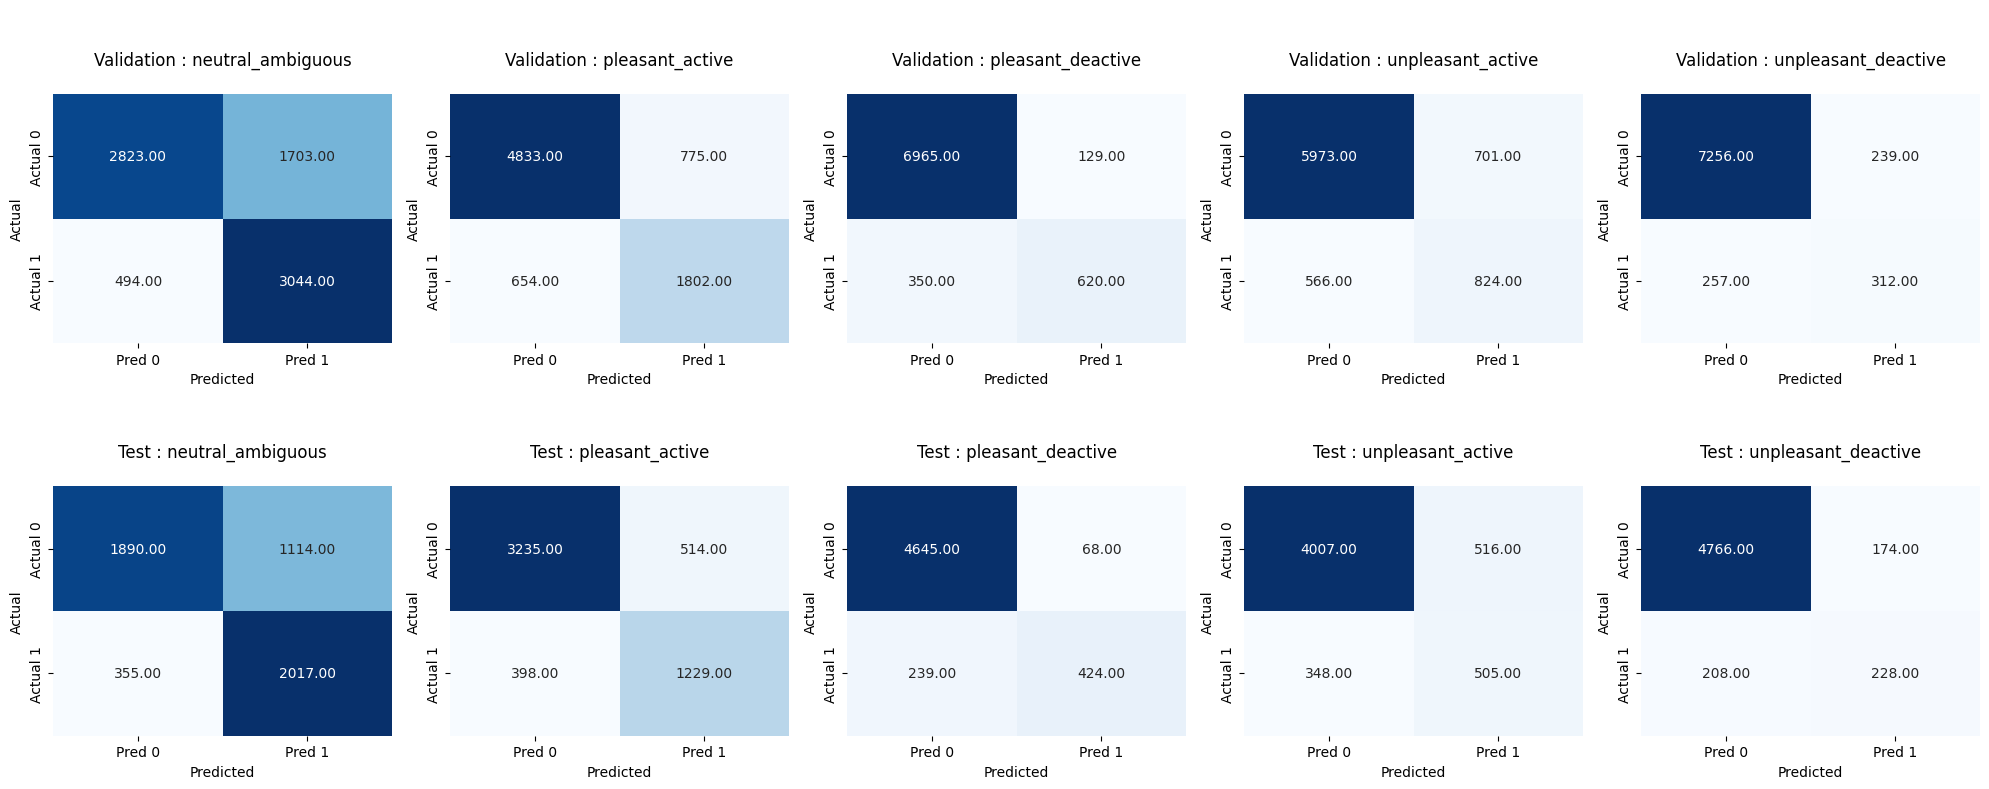

In [44]:
#compute per-category confusion matrices for val and test splits
cm_val_lr_direct_cat=utils.confusion_matrices_per_label(
    y_val_cat, val_scores_lr_cat, ts_label, categories)

cm_test_lr_direct_cat=utils.confusion_matrices_per_label(
    y_test_cat, test_scores_lr_cat,ts_label, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_lr_direct_cat, cm_test_lr_direct_cat, categories, normalize=False)

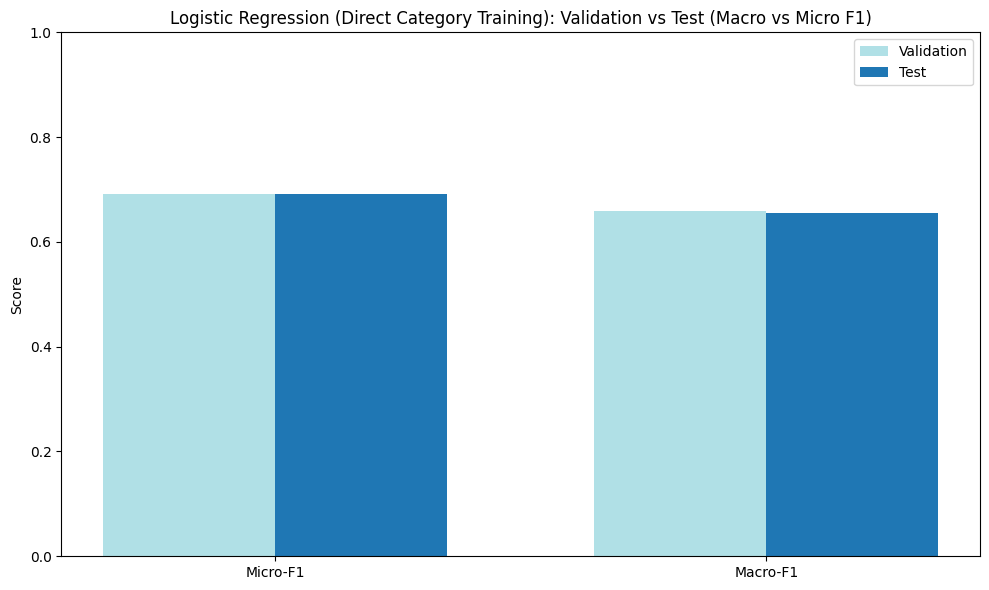

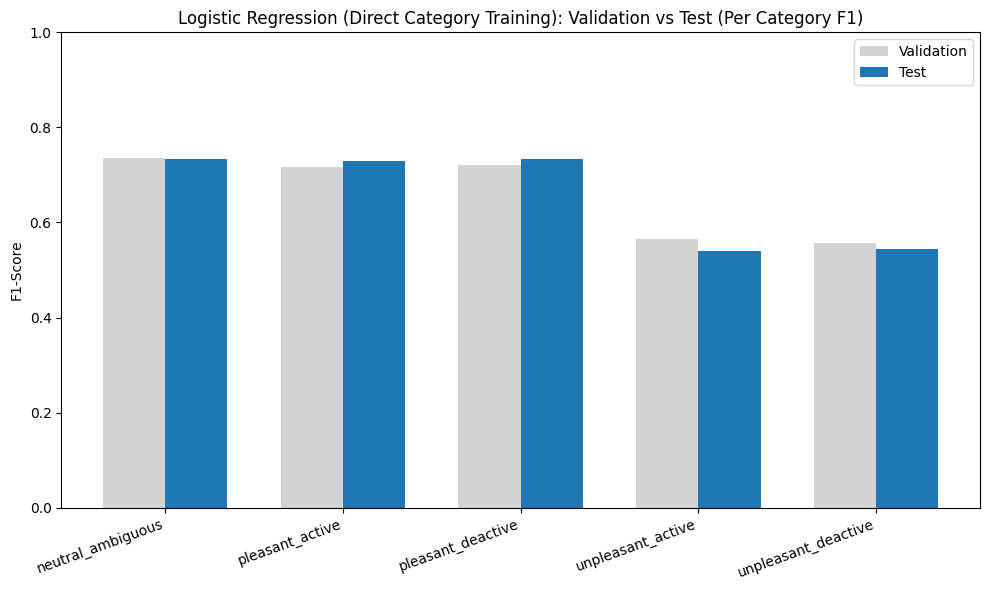

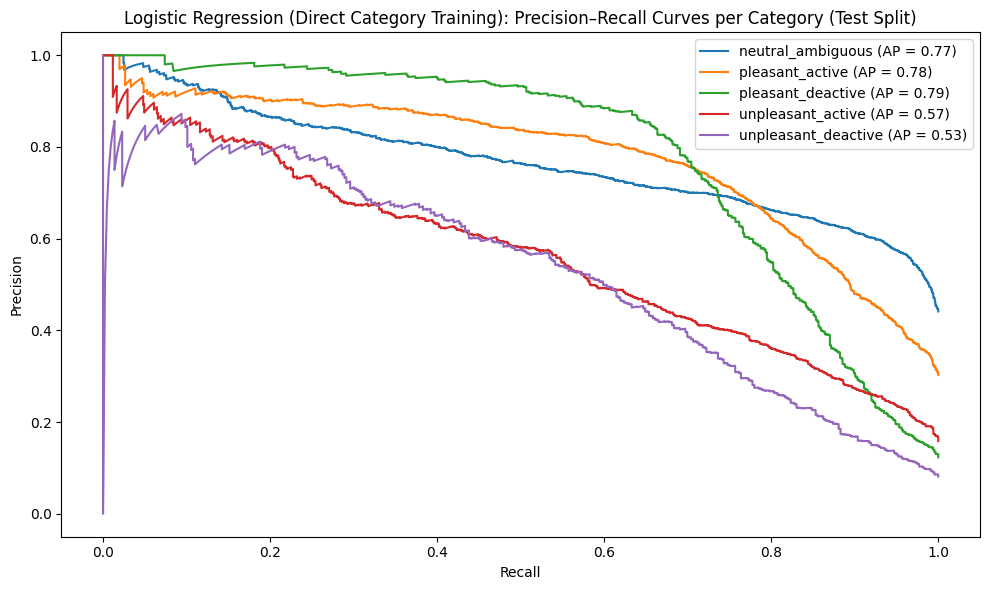

In [45]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_lr, test_metrics_lr, model_name="Logistic Regression (Direct Category Training)")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_lr, test_metrics_lr, categories, model_name="Logistic Regression (Direct Category Training)")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_lr_cat, categories, model_name="Logistic Regression (Direct Category Training)")

## 6.2. LinearSVC -  Direct Category Training

In [46]:
#LinearSVC - Direct Category Training

from sklearn.svm import LinearSVC

#initialise the LinearSVC baseline model (One-vs-Rest)
baseline_svc=OneVsRestClassifier(
    LinearSVC(
        C=1.0,
        class_weight='balanced',
        max_iter=5000,
        verbose=0
    )
)

#fit the model on train split with category-level labels
baseline_svc.fit(X_train_tfidf, y_train_cat) #fit on train split

#get raw decision scores from val and test splits
val_scores_svc_cat= np.array(baseline_svc.decision_function(X_val_tfidf))  #get raw decision scores from val split
test_scores_svc_cat= np.array(baseline_svc.decision_function(X_test_tfidf)) #get raw decision scores from test split

#compute optimal per-label thresholds using validation data
ts_label =utils.best_thresholds_per_label(val_scores_svc_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=True) #get best thresholds per category

#convert SVC decision scores to probabilities using sigmoid
val_probs_svc_cat= 1 / (1 + np.exp(-val_scores_svc_cat))
test_probs_svc_cat= 1 / (1 + np.exp(-test_scores_svc_cat))

#evaluate on val split
val_metrics_svc_cat=utils.evaluate_run(y_val_cat, val_probs_svc_cat, ts_label, label_names=categories, title="LinearSVC (Val Split): Direct Category Training\nPer-Label Thresholds\n", return_metrics=True)

#evaluate on test split
test_metrics_svc_cat=utils.evaluate_run(y_test_cat, test_probs_svc_cat, ts_label, label_names=categories, title="LinearSVC (Test Split): Direct Category Training\nPer-Label Thresholds\n", return_metrics=True)


LinearSVC (Val Split): Direct Category Training
Per-Label Thresholds

Micro F1: 0.66
Macro F1: 0.62

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.61      0.84      0.71      3538
    pleasant_active       0.65      0.73      0.69      2456
  pleasant_deactive       0.83      0.62      0.71       970
  unpleasant_active       0.47      0.58      0.52      1390
unpleasant_deactive       0.44      0.55      0.49       569

          micro avg       0.60      0.73      0.66      8923
          macro avg       0.60      0.67      0.62      8923
       weighted avg       0.61      0.73      0.66      8923
        samples avg       0.64      0.74      0.66      8923


LinearSVC (Test Split): Direct Category Training
Per-Label Thresholds

Micro F1: 0.66
Macro F1: 0.62

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.61      0.84      0.71      

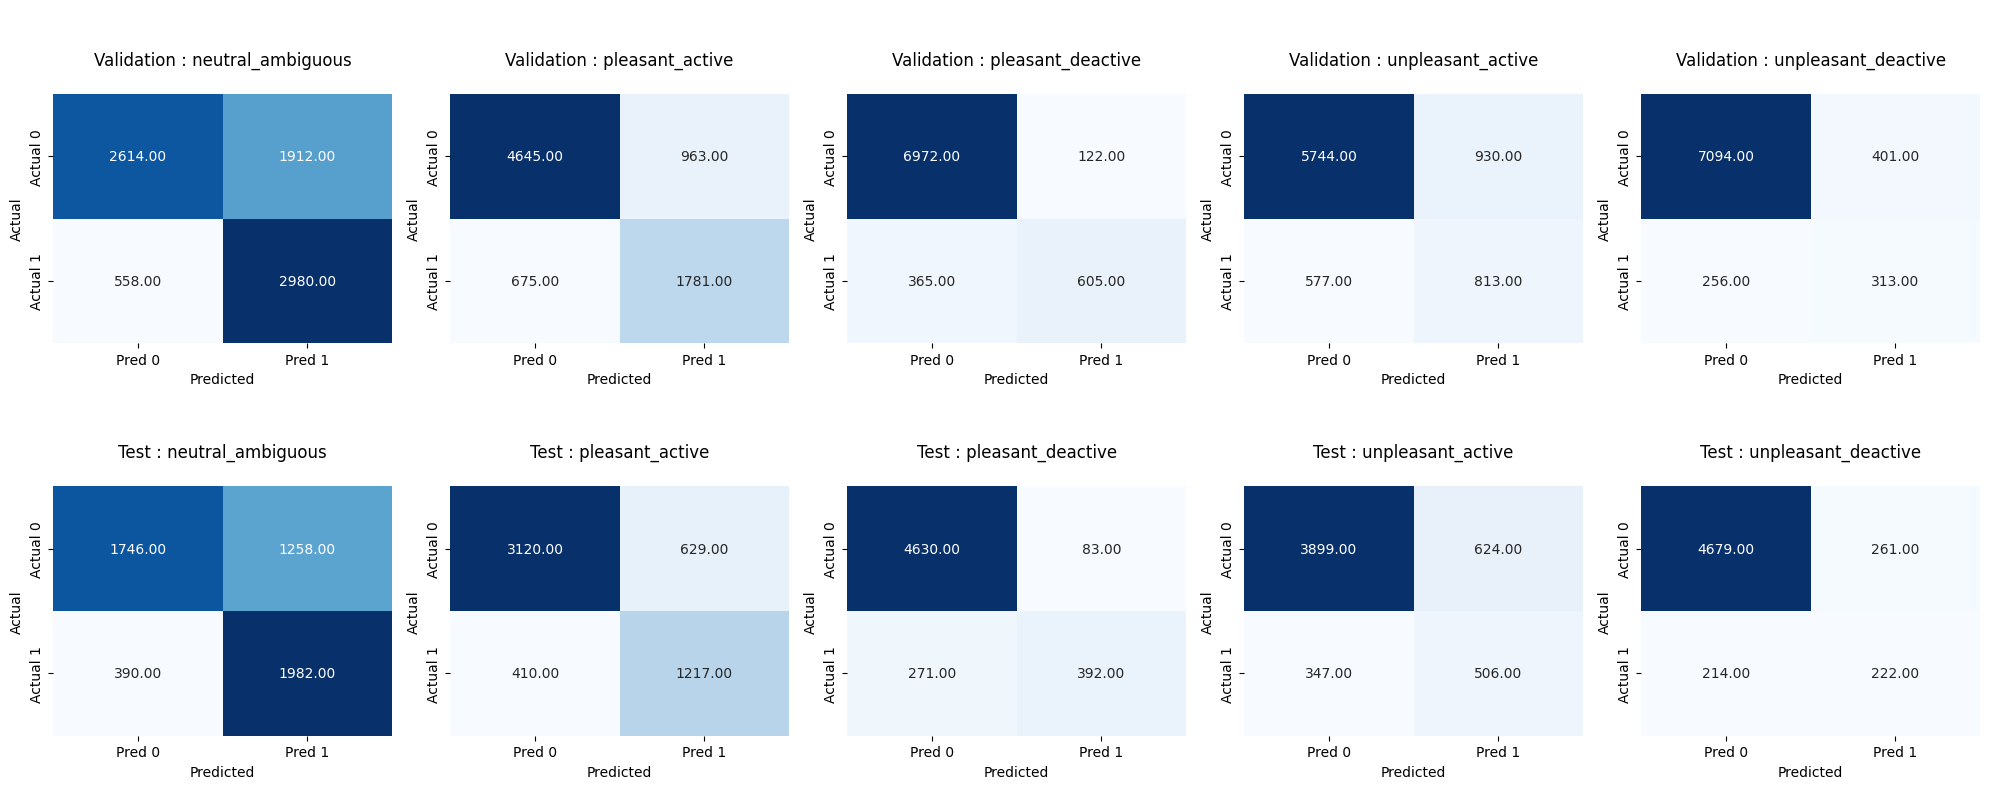

In [47]:
#compute per-category confusion matrices for val and test splits
cm_val_svc_direct_cat=utils.confusion_matrices_per_label(
    y_val_cat, val_probs_svc_cat, ts_label, categories)

cm_test_svc_direct_cat=utils.confusion_matrices_per_label(
    y_test_cat, test_probs_svc_cat,ts_label, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_svc_direct_cat, cm_test_svc_direct_cat, categories, normalize=False)

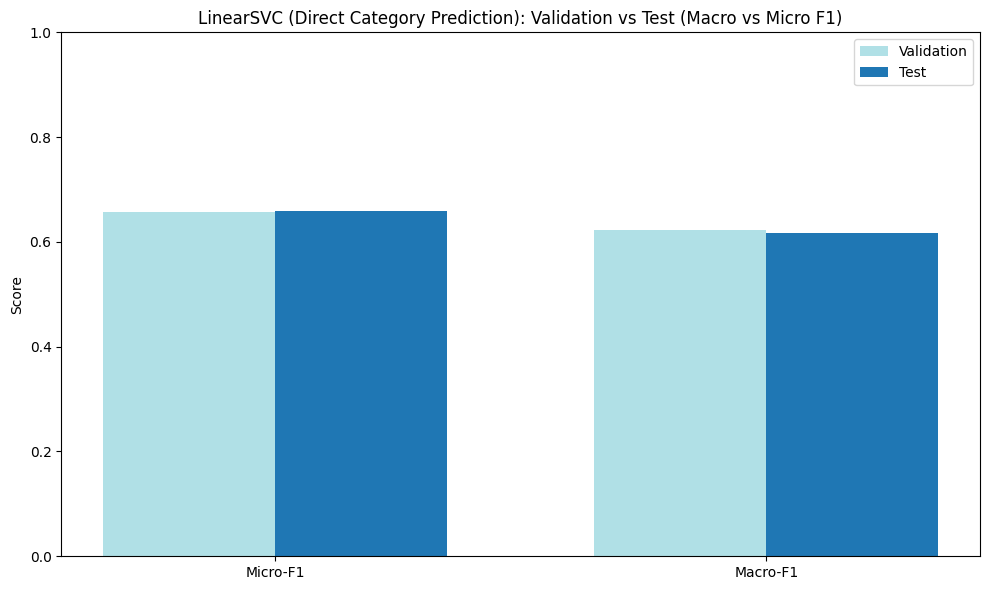

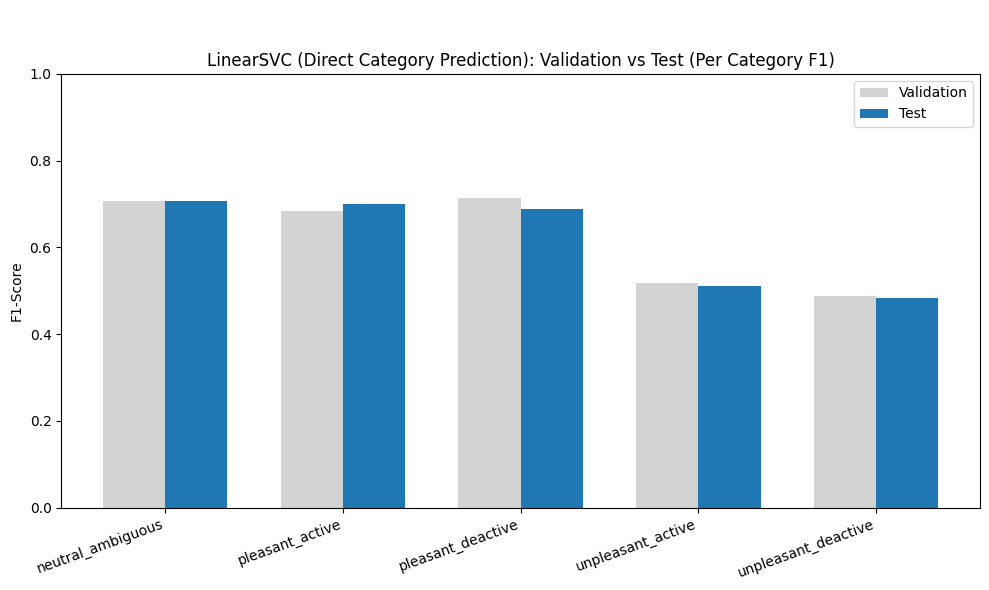

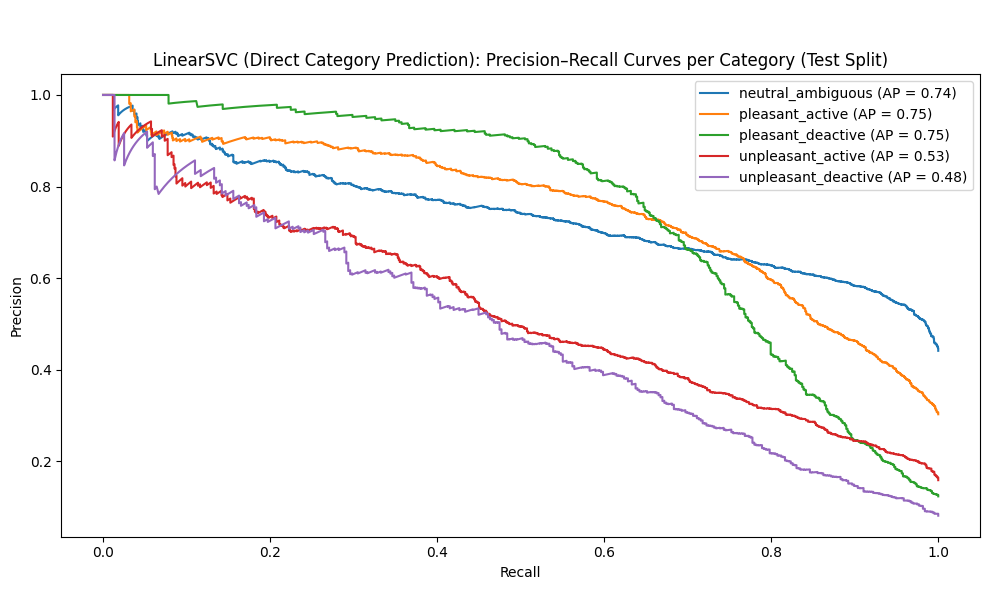

In [48]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_svc_cat, test_metrics_svc_cat, model_name="LinearSVC (Direct Category Prediction)")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_svc_cat, test_metrics_svc_cat, categories, model_name="\n\nLinearSVC (Direct Category Prediction)")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_svc_cat, categories, model_name="\n\nLinearSVC (Direct Category Prediction)")

## 6.3. LR Model -  Per Emotion Prediction to Quadrant Aggregation

### 6.3.1. LR Model - Per-Emotion Prediction


In [49]:
#Logistic Regression - Per Emotion Prediction to Quadrant Aggregation

#fit model on train split with emotion-level labels
baseline_lr_liblinear.fit(X_train_tfidf, y_train)

#get predicted probabilities from val and test split
val_scores_lr = baseline_lr_liblinear.predict_proba(X_val_tfidf)
test_scores_lr = baseline_lr_liblinear.predict_proba(X_test_tfidf)

#compute per-label thresholds
ts_label=utils.best_thresholds_per_label(val_scores_lr, y_val, n_grid=50, use_quantiles=False, scores_are_logits=False) #per emotion threshold

#evaluate model performance on val split
print("LR Model (Val Split): Per Emotion Prediction\nPer-Label Thresholds\n")
utils.evaluate_run(y_val, val_scores_lr, ts_label, label_names=mlb.classes_, title="LR + Per-Label thresholds (min-max based)")

#evaluate model performance on test split
print("LR Model (Test Split): Per Emotion Prediction\nPer-Label Thresholds\n")
utils.evaluate_run(y_test, test_scores_lr, ts_label, label_names=mlb.classes_, title="LR + Per-Label Thresholds (min-max based)")

LR Model (Val Split): Per Emotion Prediction
Per-Label Thresholds


LR + Per-Label thresholds (min-max based)
Micro F1: 0.52
Macro F1: 0.46

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.61      0.66      0.63       761
     amusement       0.66      0.86      0.75       416
         anger       0.42      0.45      0.44       310
     annoyance       0.28      0.37      0.32       494
      approval       0.34      0.34      0.34       613
        caring       0.25      0.44      0.32       190
     confusion       0.27      0.41      0.33       236
     curiosity       0.37      0.79      0.50       382
        desire       0.34      0.54      0.42       129
disappointment       0.19      0.32      0.24       230
   disapproval       0.18      0.47      0.26       426
       disgust       0.43      0.48      0.46       169
 embarrassment       0.38      0.43      0.40        49
    excitement       0.29      0.35      0

### 6.3.2. LR Model - Quadrant-Level Evaluation


In [50]:
#aggregate emotion-level predictions to category-level using noisy-or aggregation
emo_to_cat=[utils.categorize_emotion(emotions.iloc[i, 0]) for i in range(len(emotions))]
categories=sorted(set(emo_to_cat))
cat_to_emoIds={cat: [i for i, c in enumerate(emo_to_cat) if c==cat] for cat in categories}

#convert emotion-level prediction scores to category-level using noisy-or aggregation
val_scores_cat=utils.probs_emo_to_cat(val_scores_lr, categories, cat_to_emoIds, mode="noisy_or")
test_scores_cat=utils.probs_emo_to_cat(test_scores_lr, categories, cat_to_emoIds, mode="noisy_or")

#convert target labels from emotion-level to category-level
y_val_cat=utils.y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat=utils.y_to_categories(y_test, categories, cat_to_emoIds)

#compute per-label thresholds
ts_quadrant=utils.best_thresholds_per_label(val_scores_cat, y_val_cat, n_grid=50, scores_are_logits=False)

#evaluate model performance on val and test splits
val_metrics_lr_per_qua=utils.evaluate_run(y_val_cat, val_scores_cat, ts_quadrant, label_names=categories,
             title="LR Model (Val Split): Quadrant Aggregation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)
test_metrics_lr_per_qua=utils.evaluate_run(y_test_cat, test_scores_cat, ts_quadrant, label_names=categories,
             title="LR Model (Test Split): Quadrant Aggregation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)


LR Model (Val Split): Quadrant Aggregation
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.68
Macro F1: 0.65

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.62      0.86      0.72      3538
    pleasant_active       0.65      0.76      0.70      2456
  pleasant_deactive       0.78      0.64      0.70       970
  unpleasant_active       0.50      0.62      0.55      1390
unpleasant_deactive       0.53      0.59      0.55       569

          micro avg       0.62      0.75      0.68      8923
          macro avg       0.61      0.69      0.65      8923
       weighted avg       0.62      0.75      0.68      8923
        samples avg       0.66      0.77      0.68      8923


LR Model (Test Split): Quadrant Aggregation
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.68
Macro F1: 0.65

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambi

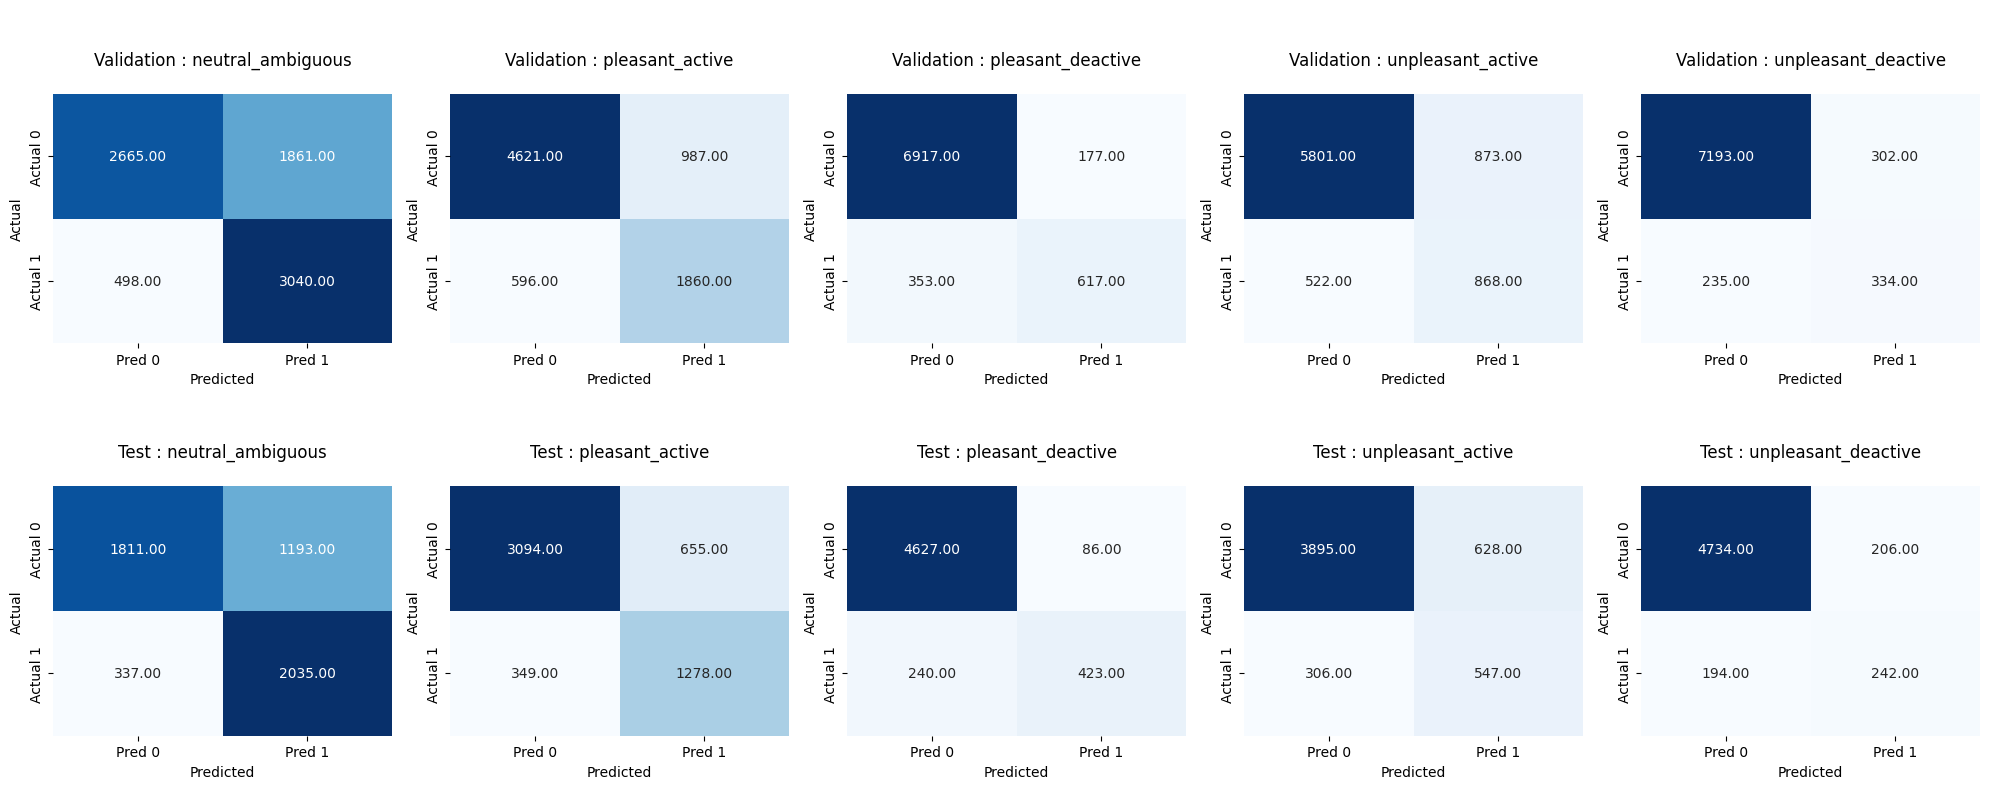

In [51]:
#compute per-category confusion matrices for val and test splits
cm_val_lr_quadrant=utils.confusion_matrices_per_label(
    y_val_cat, val_scores_cat, ts_quadrant, categories)

cm_test_lr_quadrant=utils.confusion_matrices_per_label(
    y_test_cat, test_scores_cat,ts_quadrant, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_lr_quadrant, cm_test_lr_quadrant, categories, normalize=False)

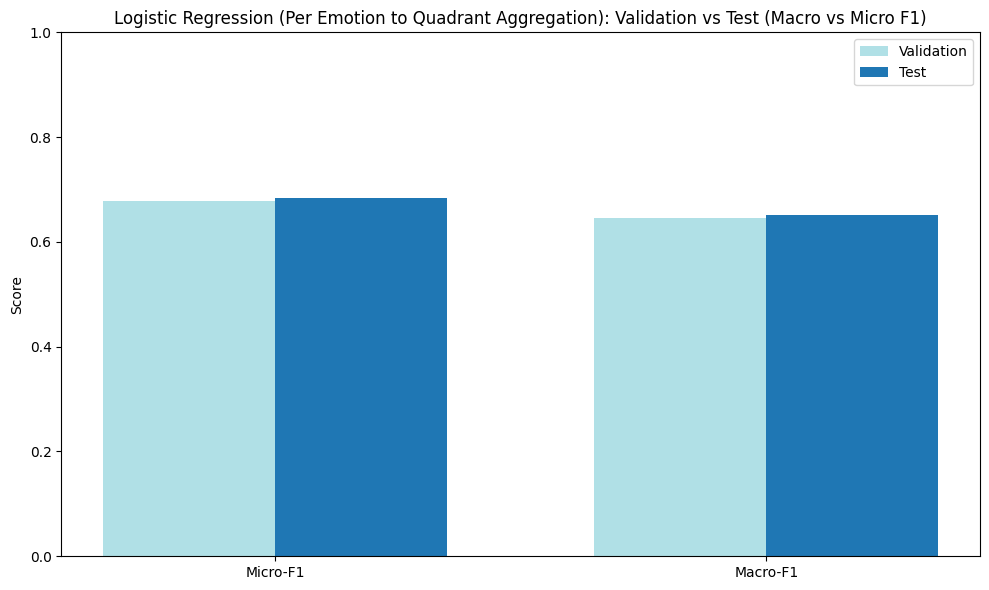

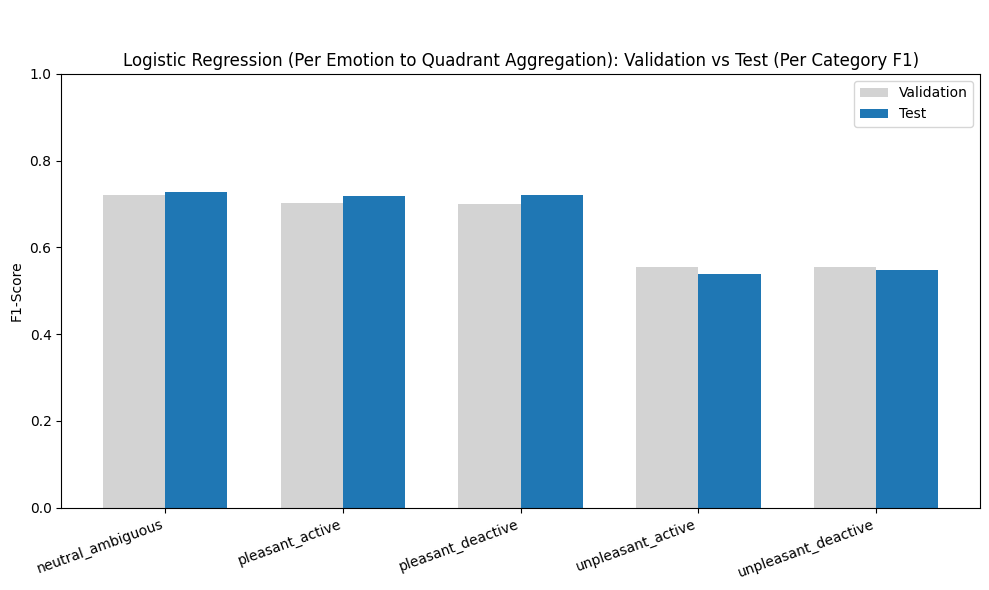

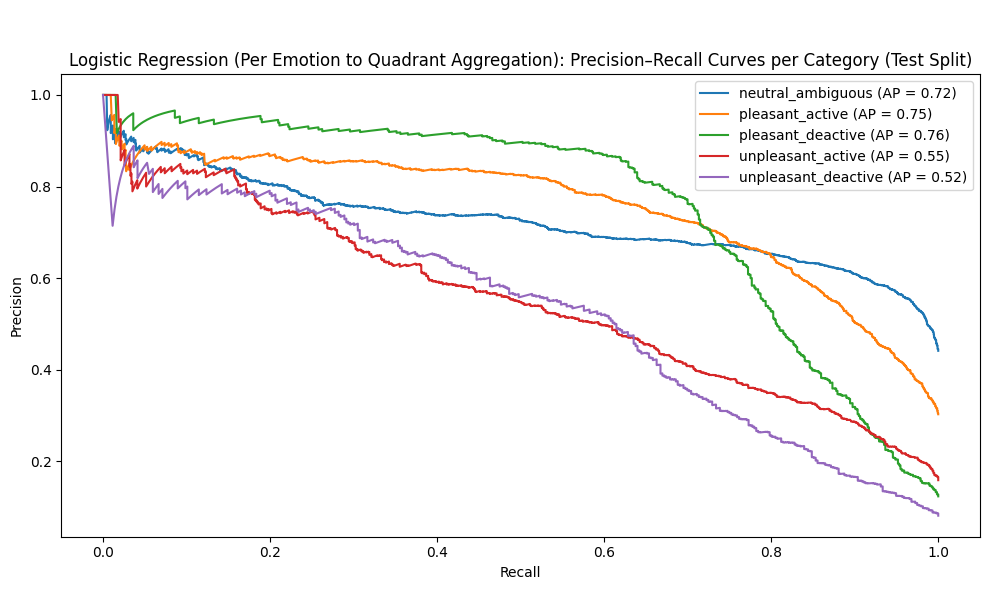

In [52]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_lr_per_qua, test_metrics_lr_per_qua, model_name="Logistic Regression (Per Emotion to Quadrant Aggregation)")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_lr_per_qua, test_metrics_lr_per_qua, categories, model_name="\n\nLogistic Regression (Per Emotion to Quadrant Aggregation)")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_cat, categories, model_name="\n\nLogistic Regression (Per Emotion to Quadrant Aggregation)")

## 6.4. LinearSVC -  Per-Emotion Prediction to Quadrant Aggregation

### 6.4.1. LinearSVC - Per-Emotion Prediction


In [53]:
#LinearSVC - Per-Emotion Prediction

#fit model on train split using emotion-level labels
baseline_svc.fit(X_train_tfidf, y_train)

#get raw decision scores from val and test splits
val_scores_svc=np.array(baseline_svc.decision_function(X_val_tfidf)) #get raw decision scores from val split
test_scores_svc=np.array(baseline_svc.decision_function(X_test_tfidf)) #get raw decision scores from test split

#compute per-label thresholds
ts_label=utils.best_thresholds_per_label(val_scores_svc, y_val, n_grid=50, use_quantiles=False, scores_are_logits=True) #get thresholds per emotion

#apply sigmoid to decsion function for evaluation
val_probs_svc= 1 / (1 + np.exp(-val_scores_svc))
test_probs_svc= 1 / (1 + np.exp(-test_scores_svc))

#evaluate on val split
utils.evaluate_run(y_val, val_probs_svc, ts_label, label_names=mlb.classes_, title="LinearSVC (Val Split): Per-Emotion Prediction\nPer-label Thresholds\n")

#evaluate on test split
utils.evaluate_run(y_test, test_probs_svc, ts_label, label_names=mlb.classes_, title="LinearSVC (Test Split): Per-Emotion Prediction\nPer-label Thresholds\n")


LinearSVC (Val Split): Per-Emotion Prediction
Per-label Thresholds

Micro F1: 0.47
Macro F1: 0.41

Detailed Classification Report:
                precision    recall  f1-score   support

    admiration       0.59      0.63      0.61       761
     amusement       0.69      0.80      0.74       416
         anger       0.33      0.42      0.37       310
     annoyance       0.19      0.43      0.27       494
      approval       0.22      0.36      0.27       613
        caring       0.27      0.33      0.30       190
     confusion       0.24      0.31      0.27       236
     curiosity       0.31      0.63      0.42       382
        desire       0.37      0.37      0.37       129
disappointment       0.17      0.18      0.17       230
   disapproval       0.15      0.41      0.22       426
       disgust       0.40      0.40      0.40       169
 embarrassment       0.25      0.47      0.33        49
    excitement       0.25      0.32      0.28       130
          fear       0.58  

### 6.4.1. LinearSVC- Quadrant-Level Evaluation

In [54]:
#Quadrant-Level Evaluation

#aggregate emotion-level prediction scores to category-level using noisy-or aggregation
val_probs_cat_svc=utils.probs_emo_to_cat(val_probs_svc, categories, cat_to_emoIds, mode="noisy_or")
test_probs_cat_svc=utils.probs_emo_to_cat(test_probs_svc, categories, cat_to_emoIds, mode="noisy_or")

#convert target labels from emotion-level to category-level
y_val_cat  = utils.y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat = utils.y_to_categories(y_test, categories, cat_to_emoIds)

#find optimal thresholds for each emotion category using val data
ts_quadrant=utils.best_thresholds_per_label(val_probs_cat_svc, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False)

#evaluate model performance on val and test splits
val_metrics_svc_per_emo=utils.evaluate_run(y_val_cat, val_probs_cat_svc, ts_quadrant, label_names=categories,
             title="LinearSVC (Val Split): Quadrant Aggregation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)
test_metrics_svc_per_emo=utils.evaluate_run(y_test_cat, test_probs_cat_svc, ts_quadrant, label_names=categories,
             title="LinearSVC (Test Split): Quadrant Aggregation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)



LinearSVC (Val Split): Quadrant Aggregation
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.64
Macro F1: 0.60

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.59      0.87      0.70      3538
    pleasant_active       0.61      0.70      0.65      2456
  pleasant_deactive       0.70      0.65      0.67       970
  unpleasant_active       0.44      0.60      0.51      1390
unpleasant_deactive       0.44      0.53      0.48       569

          micro avg       0.57      0.74      0.64      8923
          macro avg       0.56      0.67      0.60      8923
       weighted avg       0.57      0.74      0.64      8923
        samples avg       0.61      0.75      0.65      8923


LinearSVC (Test Split): Quadrant Aggregation
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.65
Macro F1: 0.60

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_am

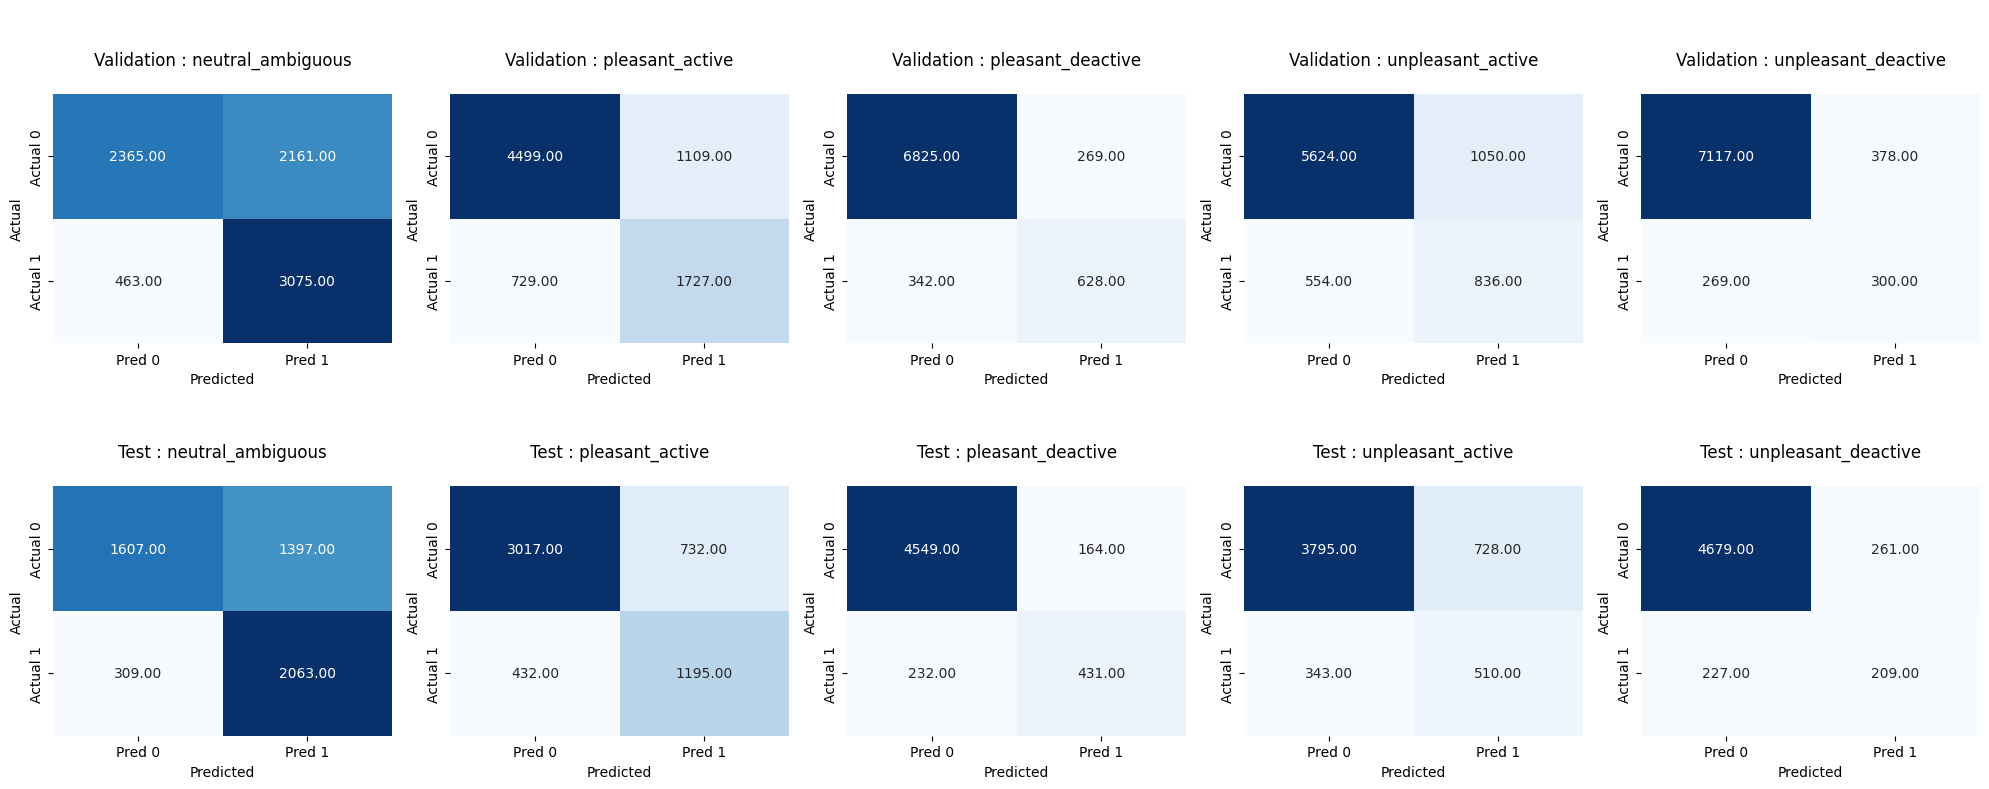

In [55]:
#compute per-category confusion matrices for val and test splits
cm_val_svc_quadrant=utils.confusion_matrices_per_label(
    y_val_cat, val_probs_cat_svc, ts_quadrant, categories)

cm_test_svc_quadrant=utils.confusion_matrices_per_label(
    y_test_cat, test_probs_cat_svc,ts_quadrant, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_svc_quadrant, cm_test_svc_quadrant, categories, normalize=False)

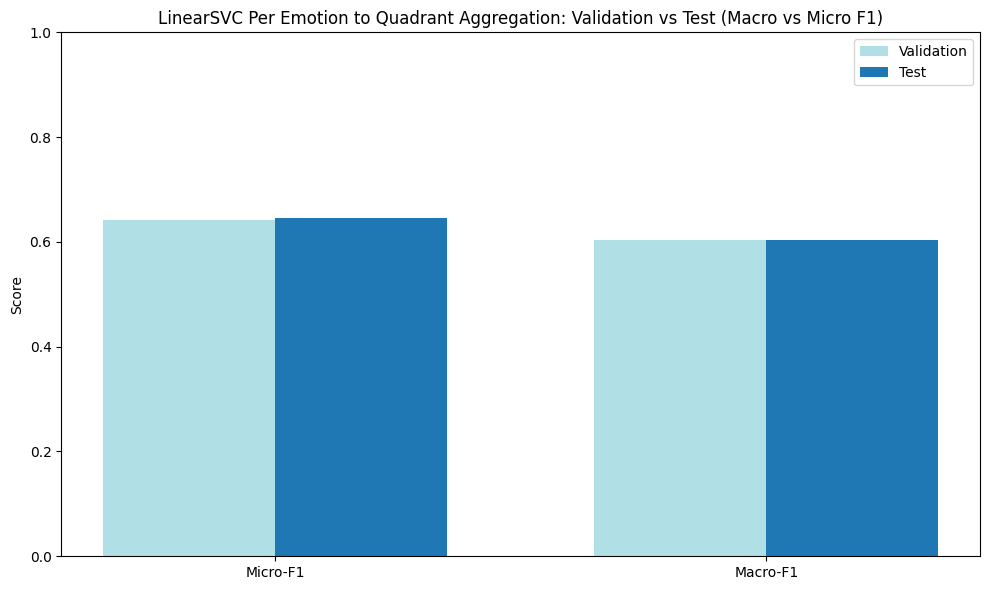

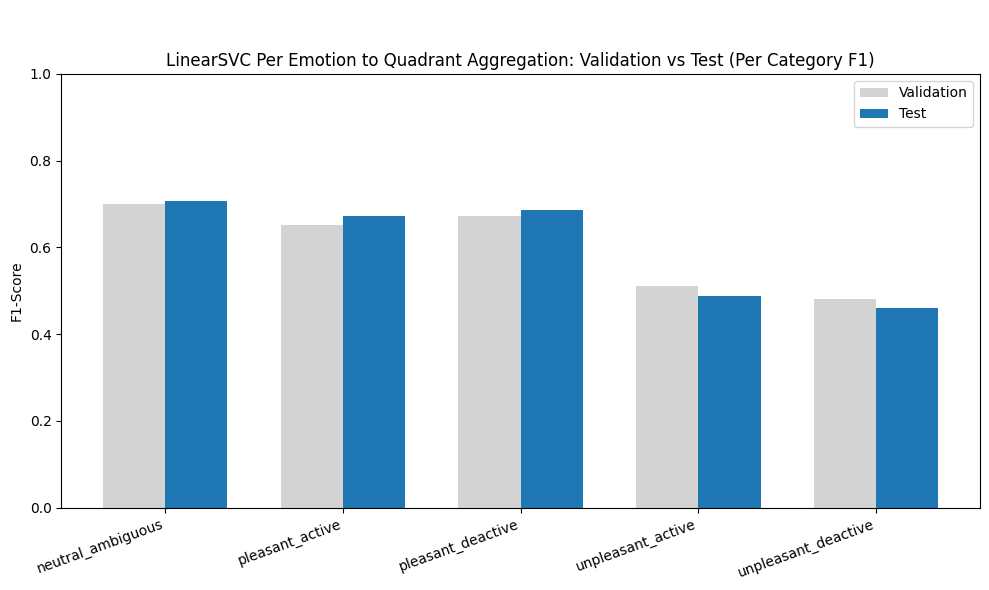

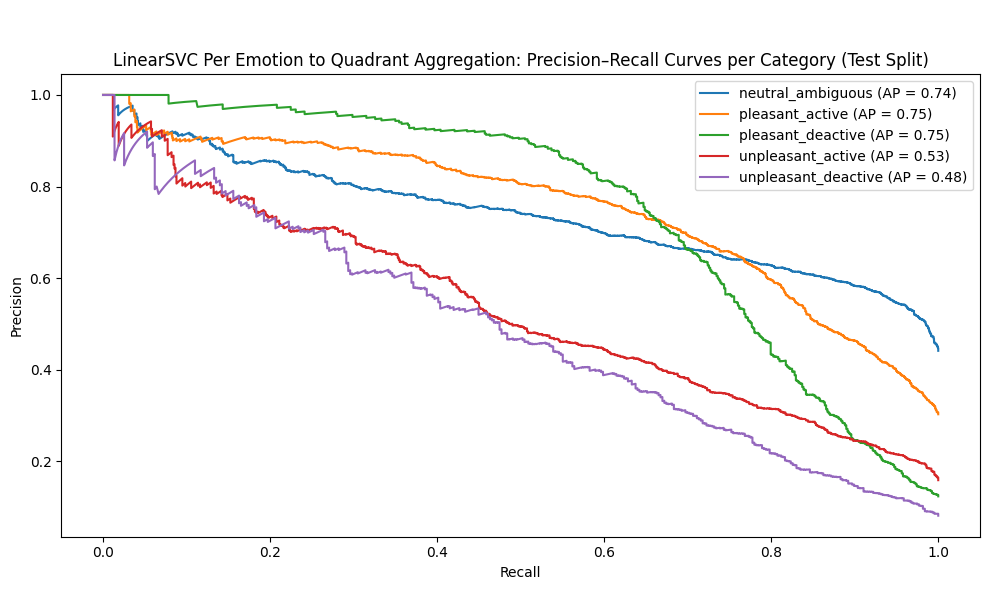

In [56]:
#compare val and test Micro-F1 and Macro-F1 scores
utils.plot_val_test_macro_micro(val_metrics_svc_per_emo, test_metrics_svc_per_emo, model_name="LinearSVC Per Emotion to Quadrant Aggregation")

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics_svc_per_emo, test_metrics_svc_per_emo, categories, model_name="\n\nLinearSVC Per Emotion to Quadrant Aggregation")

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_svc_cat, categories, model_name="\n\nLinearSVC Per Emotion to Quadrant Aggregation")

#7.Transformer Models: BERT, RoBERTa

## 7.1. Install and Import Required Libraries

In [57]:
!pip -q install torch transformers==4.44.2 accelerate scikit-learn evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 45.6 MB/s eta 0:00:00


In [58]:
import evaluate
import itertools, math, random, gc, time, traceback

## 7.2.Set Seed for Reproducibility and Device Configuration

In [59]:
#ensure reproducibility across Python, NumPy, and PyTorch
def set_seed(seed=42):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

set_seed(42)

device=torch.device("cuda" if torch.cuda.is_available() else "cpu") #select gpu if available else use cpu

## 7.3.Dataset Class for Transformers

In [60]:
#custom PyTorch dataset for multi-label emotion classification

class EmoDataset(Dataset):
  def __init__(self, texts, y, tok, max_len=80):
    self.texts=texts
    self.y=torch.tensor(y, dtype=torch.float32)
    self.tok=tok
    self.max_len=max_len

  #get the total num of texts in the dataset
  def __len__(self): return len(self.texts)

  def __getitem__(self, i):

    #tokenize one sentence at a time
    enc=self.tok(self.texts[i], truncation=True, max_length=self.max_len, padding=False, return_tensors="pt")

    #remove batch dimension added by the tokenizer
    item={k: v.squeeze(0) for k, v in enc.items()}

    #attach the corresponding multi-label target
    item["labels"]=self.y[i]
    return item

## 7.4.Loss Functions

In [61]:
#Asymmetric Loss (ASL) class
class AsymmetricLossClipped(nn.Module):

  def __init__(self, gamma_pos=1.0, gamma_neg=3, eps=0.04):
    super().__init__()
    self.gamma_pos=gamma_pos
    self.gamma_neg=gamma_neg
    self.eps=eps

  def forward(self, logits, y_true):
    #convert logits to probabilities using sigmoid
    y_hat=torch.sigmoid(logits)

    if self.eps>0:
      y_hat=y_hat.clamp(min=self.eps, max=1.0-self.eps) #clip to eps, (1-eps)

    #positive and negative sample losses
    pos_loss=-(y_true)*torch.log(y_hat)*torch.pow(1.0-y_hat, self.gamma_pos)
    neg_loss=-(1.0-y_true)*torch.log(1.0-y_hat)*torch.pow(y_hat, self.gamma_neg)

    #combine positive and negative losses and average across the batch
    loss=pos_loss+neg_loss
    return loss.sum()/logits.size(0)

#select and configure loss function
def get_criterion(loss, y_train, gamma_pos=1.0, gamma_neg=3, eps=0.04):

  #Asymmetric Loss
  if loss.lower()=="asl":
    return AsymmetricLossClipped(gamma_pos=gamma_pos, gamma_neg=gamma_neg, eps=eps)

  #Weighted Binary Cross-Entropy
  elif loss.lower()=="wbce":

    #count positive and negative occurrences per label
    pos_counts=y_train.sum(axis=0)+1e-6
    neg_counts=(y_train.shape[0]-pos_counts)+1e-6

    #assign higher weight to rarer positive labels
    pos_weight=torch.tensor(neg_counts/pos_counts, dtype=torch.float32).to(device)
    return nn.BCEWithLogitsLoss(pos_weight=pos_weight)

  else:
    raise ValueError(f"Unknown loss: {loss}")

## 7.5. Training and Evaluation

### 7.5.1. Single Configuration Training Runner

In [62]:
#runs one complete experiment: train, val-based threshold tuning, and test evaluation for a given configuration

#apply sigmoid and per-label thresholds
def apply_thresholds(logits, thresholds):
  probs=1/(1+np.exp(-logits))
  preds=(probs >= thresholds).astype(int)
  return preds, probs

def run_one_config(cfg):

  #extract hyperparameters for the current configuration
  model_name=cfg["model_name"]
  max_len=int(cfg["max_len"])
  batch_size=int(cfg["batch_size"])
  lr=float(cfg["lr"])
  epochs=int(cfg["epochs"])
  loss=cfg["loss"]
  gamma_pos=float(cfg["gamma_pos"])
  gamma_neg=float(cfg["gamma_neg"])
  eps=float(cfg["eps"])
  warmup_ratio=float(cfg["warmup_ratio"])
  weight_decay=float(cfg["weight_decay"])

  #load tokenizer for the selected transformer model
  tokenizer=AutoTokenizer.from_pretrained(model_name)

  #construct train, val, and test datasets
  train_ds=EmoDataset(X_train_transformer, y_train, tokenizer, max_len=max_len)
  val_ds=EmoDataset(X_val_transformer, y_val, tokenizer, max_len=max_len)
  test_ds=EmoDataset(X_test_transformer, y_test, tokenizer, max_len=max_len)

  #dynamically pad batches to the longest sequence in each batch
  collator=DataCollatorWithPadding(tokenizer)

  #load transformer model
  model=AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=y_train.shape[1], problem_type="multi_label_classification").to(device)

  #initialise loss function
  criterion=get_criterion(loss, y_train, gamma_pos=gamma_pos, gamma_neg=gamma_neg, eps=eps)

  #custom loss computation to integrate the selected criterion with Trainer
  def compute_loss(model, inputs, return_outputs=False,**kwargs):
    labels=inputs.pop("labels") #remove 'labels' from inputs dictionary
    outputs=model(**inputs)     #feed the remaining inputs to the model
    logits=outputs.logits       #extract the logits from model outputs
    loss=criterion(logits, labels.to(logits.dtype))  #compute the loss between predicted logits and true labels
    return (loss, outputs) if return_outputs else loss

  #training configuration for the current run
  args=TrainingArguments(
    output_dir=f"./emo-{model_name.split('/')[0]}/{int(time.time())}",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=max(16, batch_size),
    num_train_epochs=epochs,
    weight_decay=weight_decay,
    lr_scheduler_type="linear",
    warmup_ratio=warmup_ratio,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    optim="adamw_torch",
    fp16=torch.cuda.is_available(),
    logging_steps=50,
    report_to=["none"],
    save_total_limit=2
  )

  #initialise Trainer with early stopping
  trainer=Trainer(
      model=model,
      args=args,
      train_dataset=train_ds,
      eval_dataset=val_ds,
      tokenizer=tokenizer,
      data_collator=collator,
      callbacks=[
          EarlyStoppingCallback(
              early_stopping_patience=2,
              early_stopping_threshold=0.0
          )
      ]
  )

  #use custom loss function during training
  trainer.compute_loss=compute_loss

  #train the model
  trainer.train()

  #run validation inference and tune per-label decision thresholds
  val_out = trainer.predict(val_ds)
  val_logits = val_out.predictions
  ts_label=utils.best_thresholds_per_label(val_logits, y_val, n_grid=80, use_quantiles=False, scores_are_logits=True)
  val_preds_perlabel_tuned, val_probs_perlabel_tuned=apply_thresholds(val_logits, ts_label)
  val_macro_perlabel_tuned= f1_score(y_val, val_preds_perlabel_tuned, average="macro", zero_division=0)
  val_micro_perlabel_tuned= f1_score(y_val, val_preds_perlabel_tuned, average="micro", zero_division=0)

  #compute validation performance using a fixed 0.5 threshold baseline
  baseline_ts=utils.baseline_thresholds(y_val)
  val_preds_baseline_ts, val_probs_baseline=apply_thresholds(val_logits, baseline_ts)
  val_macro_baseline_ts= f1_score(y_val, val_preds_baseline_ts, average="macro", zero_division=0)
  val_micro_baseline_ts= f1_score(y_val, val_preds_baseline_ts, average="micro", zero_division=0)

  #run test inference using thresholds tuned on the validation set
  test_out = trainer.predict(test_ds)
  test_logits = test_out.predictions

  #evaluate on test set using thresholds derived from validation data
  test_preds_perlabel_tuned, test_probs_perlabel_tuned=apply_thresholds(test_logits, ts_label)
  test_macro_perlabel_tuned= f1_score(y_test, test_preds_perlabel_tuned, average="macro", zero_division=0)
  test_micro_perlabel_tuned= f1_score(y_test, test_preds_perlabel_tuned, average="micro", zero_division=0)

  test_preds_baseline_ts, test_probs_baseline_ts=apply_thresholds(test_logits, baseline_ts)
  test_macro_baseline_ts= f1_score(y_test, test_preds_baseline_ts, average="macro", zero_division=0)
  test_micro_baseline_ts= f1_score(y_test, test_preds_baseline_ts, average="micro", zero_division=0)

  #aggregate evaluation metrics and configuration details for this run
  result={
    "val_macro":float(val_macro_perlabel_tuned),
    "val_micro":float(val_micro_perlabel_tuned),
    "test_macro":float(test_macro_perlabel_tuned),
    "test_micro":float(test_micro_perlabel_tuned),

    "val_macro_0.5_ts":float(val_macro_baseline_ts),
    "val_micro_0.5_ts":float(val_micro_baseline_ts),
    "test_macro_0.5_ts":float(test_macro_baseline_ts),
    "test_micro_0.5_ts":float(test_micro_baseline_ts),

    "thresholds":ts_label,
    "cfg": cfg
  }

  #convert model outputs to NumPy arrays
  def _to_numpy(x):
      if hasattr(x, "detach"):
          x = x.detach().cpu().numpy()
      return np.asarray(x)

  val_logits_np  = _to_numpy(val_out.predictions)
  test_logits_np = _to_numpy(test_out.predictions)

  #store logits in the result dictionary
  result.update({
      "val_logits":  val_logits_np,
      "test_logits": test_logits_np,

  })

  #release resources before the next run
  del trainer, model
  torch.cuda.empty_cache()
  gc.collect()
  return result

### 7.5.2.Transformers Configurations Grid and Search Helper

In [63]:
#define experiment configurations for grid search across BERT and RoBERTa

#BERT Base Configuration
grid_bert={
    "model_name": ["bert-base-uncased"],
    "loss": ["asl"],
    "gamma_pos": [1.0],
    "gamma_neg": [3.0],
    "eps":[0.03],
    "lr":[5e-5],
    "batch_size":[32],
    "epochs":[4],
    "max_len":[128],
    "warmup_ratio":[0.06],
    "weight_decay":[0.01]
}

#RoBERTa Base Configuration
grid_roberta={
    "model_name": ["roberta-base"],
    "loss": ["asl"],
    "gamma_pos": [1.0],
    "gamma_neg": [3.0],
    "eps":[0.03],
    "lr":[5e-5],
    "batch_size":[64],
    "epochs":[4],
    "max_len":[128],
    "warmup_ratio":[0.06],
    "weight_decay":[0.01]
}

#generate all hyperparameter combinations
def dict_product(d):
  keys=list(d.keys())
  for values in itertools.product(*(d[k] for k in keys)):
    yield dict(zip(keys, values))

#generate configurations for each model
cfgs_bert=list(dict_product(grid_bert))
cfgs_roberta=list(dict_product(grid_roberta))

#combine model identifiers with their respective configurations
experiment_cfgs=[("bert-base-uncased", cfg) for cfg in cfgs_bert] + [("roberta-base", cfg) for cfg in cfgs_roberta]

### 7.5.3.Experimental Execution

In [64]:
#run grid search experiments, track the best configuration per model, and select overall best model based on val macro-F1

best_per_model={} #store best result per model
history=[]        #store results from all runs

#iterate over all experiment configurations
for i, (model_key, cfg) in enumerate(experiment_cfgs, 1):
    print(f"\n[{i}/{len(experiment_cfgs)}] Running {model_key} with cfg: {cfg}")
    try:
        set_seed(42)
        result=run_one_config(cfg)
        history.append(result)
        model_name= cfg["model_name"]

        #update best result for the current model based on val macro-F1
        if model_name not in best_per_model:
          best_per_model[model_name]=result
        else:
          if result["val_macro"] > best_per_model[model_name]["val_macro"]:
            best_per_model[model_name]=result
        print(f"{model_name}: Val macro-F1={result['val_macro']:.4f}, micro-F1={result['val_micro']:.4f}")

    #handle runtime errors
    except RuntimeError as e:
        msg = str(e)
        print("RuntimeError:", msg)
        if "CUDA out of memory" in msg:
            print("GPU Out of Memory")
        else:
            traceback.print_exc()

    except Exception as e:
        print("Exception:", e)
        traceback.print_exc()

    #release gpu memory after each run
    finally:
        torch.cuda.empty_cache(); gc.collect()

#report the best configuration per model
print("\nPer model best results\n")
for model_name, res in best_per_model.items():
  print("Model:", model_name)
  print("Best Configuration:", res['cfg'])
  print(f"Val  macro-F1 using per-label threshold {res['val_macro']:.4f} | micro-F1 {res['val_micro']:.4f}")
  print(f"Test macro-F1 using per-label threshold {res['test_macro']:.4f} | micro-F1 {res['test_micro']:.4f}")
  print(f"Val  macro-F1 using a fixed 0.5 threshold {res['val_macro_0.5_ts']:.4f} | micro-F1 {res['val_micro_0.5_ts']:.4f}")
  print(f"Test macro-F1 using a fixed 0.5 threshold {res['test_macro_0.5_ts']:.4f} | micro-F1 {res['test_micro_0.5_ts']:.4f}")
  print("_"*70)

#select and report the overall best configuration across all models
overall_best=max(best_per_model.values(), key=lambda r: r["val_macro"])
print("\nOverall best model\n")
print("Best cfg:", overall_best['cfg'])
print(f"Val  macro-F1 using per-label threshold {overall_best['val_macro']:.4f} | micro-F1 {overall_best['val_micro']:.4f}")
print(f"Test macro-F1 using per-label threshold {overall_best['test_macro']:.4f} | micro-F1 {overall_best['test_micro']:.4f}")
print(f"Val  macro-F1 using a fixed 0.5 threshold {overall_best['val_macro_0.5_ts']:.4f} | micro-F1 {overall_best['val_micro_0.5_ts']:.4f}")
print(f"Test macro-F1 using a fixed 0.5 threshold {overall_best['test_macro_0.5_ts']:.4f} | micro-F1 {overall_best['test_micro_0.5_ts']:.4f}")


[1/2] Running bert-base-uncased with cfg: {'model_name': 'bert-base-uncased', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 32, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2664673986.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


Epoch,Training Loss,Validation Loss
1,0.650300,0.645929
2,0.558400,0.638283
3,0.418200,0.703874
4,0.327700,0.792823


bert-base-uncased: Val macro-F1=0.5406, micro-F1=0.6043

[2/2] Running roberta-base with cfg: {'model_name': 'roberta-base', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 64, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2664673986.py:73: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer=Trainer(


Epoch,Training Loss,Validation Loss
1,0.657700,0.653961
2,0.592700,0.639548
3,0.508800,0.648690
4,0.460100,0.667491


roberta-base: Val macro-F1=0.5399, micro-F1=0.6051

Per model best results

Model: bert-base-uncased
Best Configuration: {'model_name': 'bert-base-uncased', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 32, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}
Val  macro-F1 using per-label threshold 0.5406 | micro-F1 0.6043
Test macro-F1 using per-label threshold 0.5058 | micro-F1 0.5930
Val  macro-F1 using a fixed 0.5 threshold 0.5016 | micro-F1 0.6008
Test macro-F1 using a fixed 0.5 threshold 0.5046 | micro-F1 0.6067
______________________________________________________________________
Model: roberta-base
Best Configuration: {'model_name': 'roberta-base', 'loss': 'asl', 'gamma_pos': 1.0, 'gamma_neg': 3.0, 'eps': 0.03, 'lr': 5e-05, 'batch_size': 64, 'epochs': 4, 'max_len': 128, 'warmup_ratio': 0.06, 'weight_decay': 0.01}
Val  macro-F1 using per-label threshold 0.5399 | micro-F1 0.6051
Test macro-F1 using per-label thresh

## 7.6. Quadrant-Level Evaluation

In [65]:
#convert best model logits to probabilities using sigmoid
val_probs_emo=1/(1+np.exp(-overall_best["val_logits"]))
test_probs_emo=1/(1+np.exp(-overall_best["test_logits"]))

#convert emotion-level labels to category-level labels
y_val_cat=utils.y_to_categories(y_val, categories, cat_to_emoIds)
y_test_cat=utils.y_to_categories(y_test, categories, cat_to_emoIds)

In [66]:
#convert emotion-level probabilities to category-level probabilities using noisy-or aggregation
val_scores_cat = utils.probs_emo_to_cat(val_probs_emo, categories, cat_to_emoIds, mode="noisy_or")
test_scores_cat = utils.probs_emo_to_cat(test_probs_emo, categories, cat_to_emoIds, mode="noisy_or")

#compute per-label thresholds for each category using val data
ts_cat=utils.best_thresholds_per_label(val_scores_cat, y_val_cat, n_grid=50, use_quantiles=False, scores_are_logits=False)

#evaluate category-level model performance on val and test sets
val_metrics=utils.evaluate_run(y_val_cat, val_scores_cat, ts_cat, label_names=categories,
             title="Best Transformer (Val Split): Quadrant-Level Evaluation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)

test_metrics=utils.evaluate_run(y_test_cat, test_scores_cat, ts_cat, label_names=categories,
             title="Best Transformer (Test Split): Quadrant-Level Evaluation\nPer-label Thresholds with Noisy_or Aggregation\n", return_metrics=True)


Best Transformer (Val Split): Quadrant-Level Evaluation
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.73
Macro F1: 0.70

Detailed Classification Report:
                     precision    recall  f1-score   support

  neutral_ambiguous       0.70      0.84      0.76      3538
    pleasant_active       0.75      0.79      0.77      2456
  pleasant_deactive       0.81      0.71      0.76       970
  unpleasant_active       0.60      0.67      0.63      1390
unpleasant_deactive       0.56      0.61      0.58       569

          micro avg       0.70      0.77      0.73      8923
          macro avg       0.68      0.72      0.70      8923
       weighted avg       0.70      0.77      0.73      8923
        samples avg       0.73      0.79      0.74      8923


Best Transformer (Test Split): Quadrant-Level Evaluation
Per-label Thresholds with Noisy_or Aggregation

Micro F1: 0.73
Macro F1: 0.70

Detailed Classification Report:
                     precision    recall  f1-score

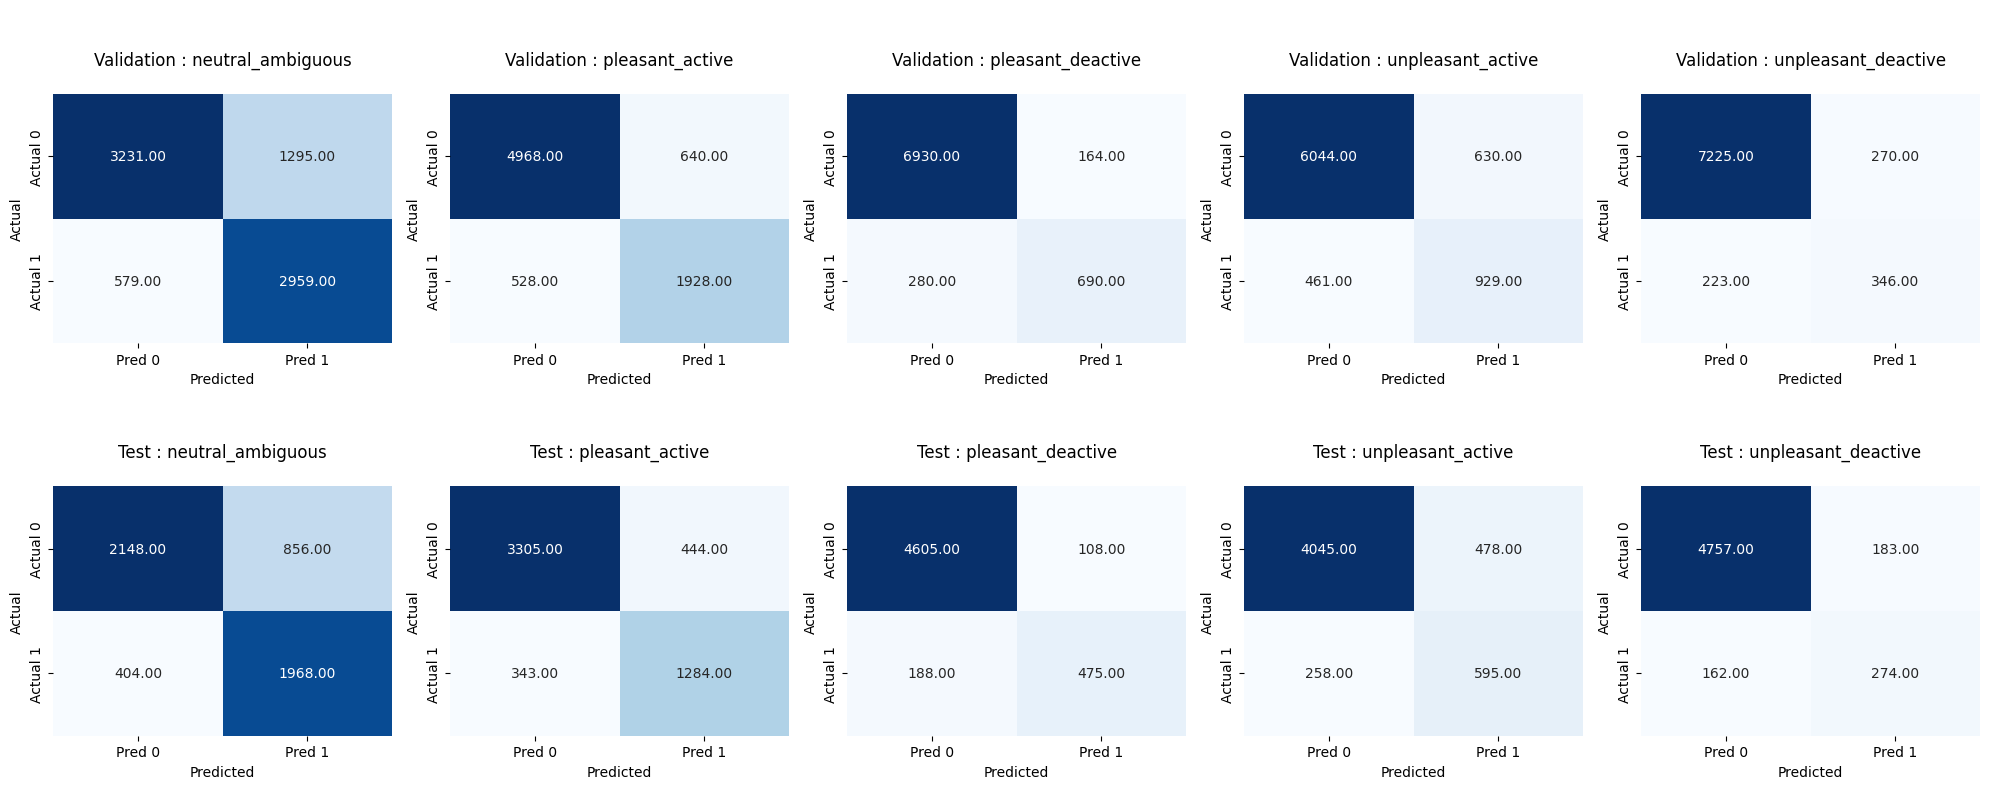

In [67]:
#compute per-quadrant confusion matrices for val and test splits
cm_val_transformer=utils.confusion_matrices_per_label(
    y_val_cat, val_scores_cat, ts_cat, categories)

cm_test_transformer=utils.confusion_matrices_per_label(
    y_test_cat, test_scores_cat,ts_cat, categories)

#plot val and test confusion matrices for each category
utils.plot_cm(cm_val_transformer, cm_test_transformer, categories, normalize=False)

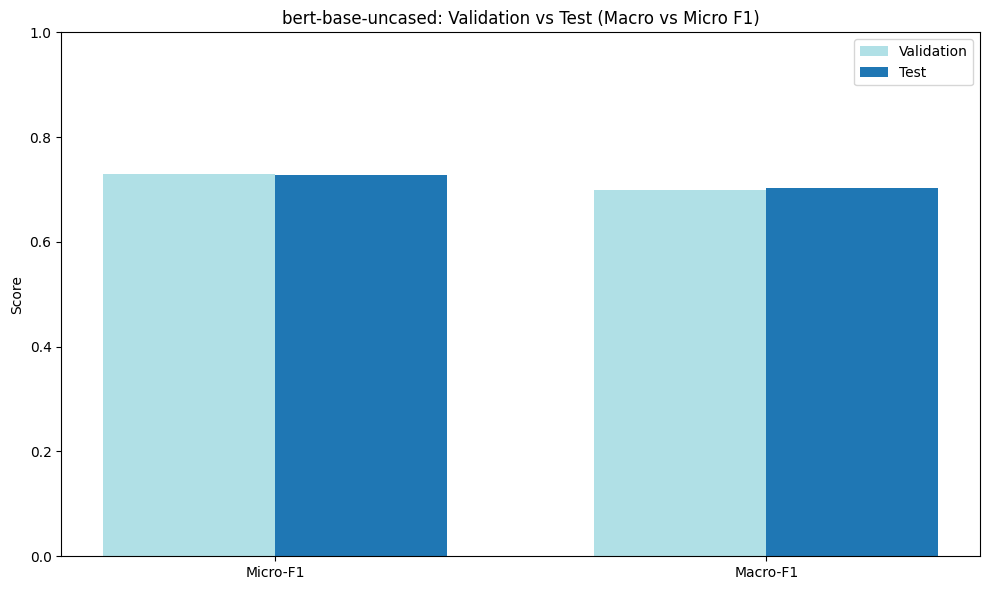

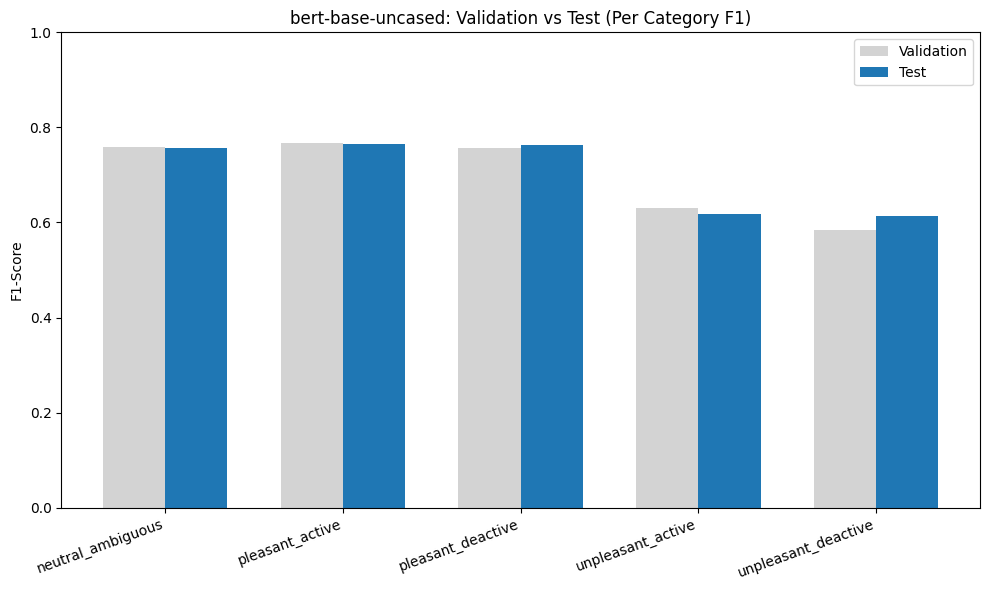

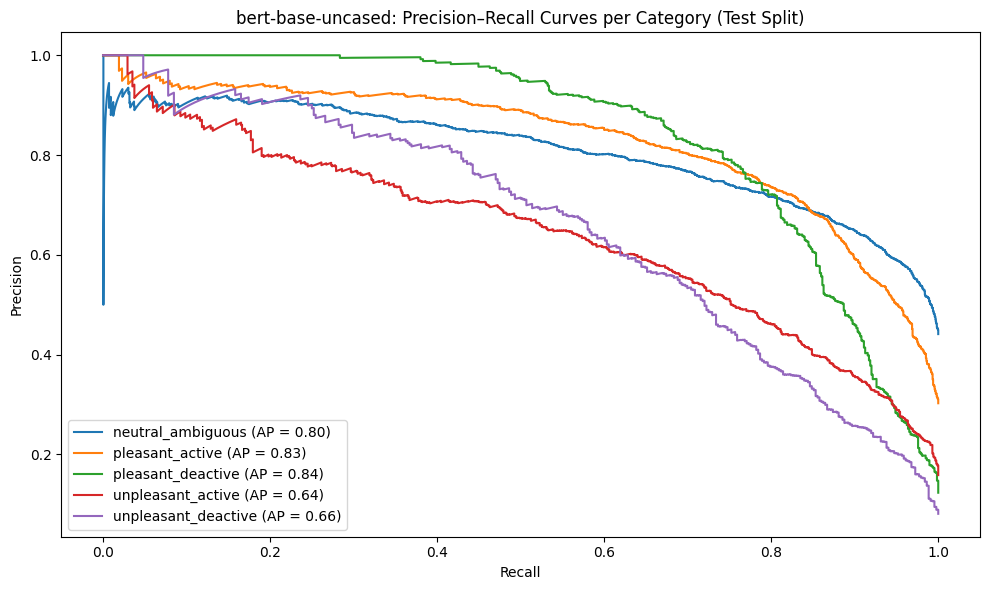

In [68]:
#compare val and test Micro-F1 and Macro-F1 scores for the selected best model
utils.plot_val_test_macro_micro(val_metrics, test_metrics, model_name=overall_best["cfg"]["model_name"])

#compare per-category F1-scores between val and test splits
utils.plot_val_test_per_cat_f1(val_metrics, test_metrics, categories, model_name=overall_best["cfg"]["model_name"])

#plot precision-recall curves for each category on the test split
utils.plot_pr_curves_per_cat(y_test_cat, test_scores_cat, categories, model_name=overall_best["cfg"]["model_name"])

# 8.Map Burnout Indicators from Predicted Quadrants

In [69]:
#determine a burnout-related indicator from quadrant-level predictions using rule-based priority scheme

def burnout_indicator_from_quadrants(pred_row, col_idx):

  #extract binary predictions for each affective quadrant
  NEU=int((pred_row[col_idx["neutral_ambiguous"]]))
  PA=int((pred_row[col_idx["pleasant_active"]]))
  PD=int((pred_row[col_idx["pleasant_deactive"]]))
  NA=int((pred_row[col_idx["unpleasant_active"]]))
  ND=int((pred_row[col_idx["unpleasant_deactive"]]))

  #assign a burnout-related indicator using a rule-based priority
  if ND:
    return "Signs of Advanced Burnout (Exhaustion/Ineffectiveness)"
  elif NA:
    return "Signs of Moderate Burnout (Stress/Cynicism)"
  elif PA:
    return "Indicators of Engagement (No Apparent Signs of Burnout)"
  elif PD:
    return "Indicators of Satisfaction (No Apparent Signs of Burnout)"
  elif NEU:
    return "Ambiguous Burnout Indicator"
  else:
    return "Ambiguous Burnout Indicator"

In [70]:
#convert category probabilities to binary predictions using per-label thresholds
preds_cat = (test_scores_cat >= ts_cat).astype(int)

#map quadrant names to their corresponding column indices
col_idx = {c:i for i,c in enumerate(categories)}

#generate burnout-related indicator for each test
labels = [burnout_indicator_from_quadrants(row, col_idx) for row in preds_cat]

In [71]:
#summarise distribution of burnout-related indicators across the test set
pd.Series(labels).value_counts()

,count
Ambiguous Burnout Indicator,1918
Indicators of Engagement (No Apparent Signs of Burnout),1641
Signs of Moderate Burnout (Stress/Cynicism),943
Signs of Advanced Burnout (Exhaustion/Ineffectiveness),457
Indicators of Satisfaction (No Apparent Signs of Burnout),417
